## Bring the Avengers!
libraries that will ease our data analysis

In [83]:
import matplotlib  #导入matplotlib库，是python上的一个2D绘图库，用于数据可视化作图。
import pandas as pd  #pandas是基于numpy的一种工具，提供了大量能使我们快速便捷地处理数据的函数和方法。
import numpy as np  #NumPy系统是Python的一种开源的数值计算扩展。这种工具可用来存储和处理大型矩阵。
import matplotlib.pyplot as plt # default library for making plots 系统默认作图的图书馆；matplotlib.pyplot是一个有命令风格的函数集合，它看起来和MATLAB很相似。
import seaborn as sns # for making prettier plots!   使用调色板对作图调色
import datetime   #datetime获取时间的一个库，并且可以输出自己想要的格式3

import math

import warnings                        #10、11行是为了忽略了警告错误的输出。python开发中经常遇到报错的情况，但是warning通常并不影响程序的运行，而且有时特别讨厌，下面我们来说下如何忽略warning错误
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # to see all columns in the pd dataframe，设置最大显示列数为全部列
%config InlineBackend.figure_format = 'retina' # for the crispier version of plots for retina screens
     #14行是解决matplotlib在Retina屏幕中显示模糊问题，Retina屏幕是一种新型高分辨率显示标准的屏幕，苹果电脑手机用这种标准。

matplotlib.style.use('ggplot')   #ggplot2以美轮美奂的统计制图能力一定能排进各类绘图软件的前三
plt.rcParams['figure.figsize'] = [12.0, 6.0]   #设置图像窗口尺寸大小为12.0*6.0,plt.rcParams设置画图的分辨率，大小等信息

## Importing the Dataset

In [84]:
filename = 'database_main_copy.xls'
filename2 = 'database_main.xls' 

data = pd.read_excel(filename, sheet_name="main", converters= {'Date': pd.to_datetime})  #对excel文件返回main表，对Data用转换器转为显示时间
data.set_index(pd.to_datetime(data.Date),inplace=True)   #设置索引？？？，括号里逗号左边是设置转换时间格式，逗号后面是inplace为True时，索引将会还原为列，不太懂括号后面里什么意思，

print("Loaded db successfully!")   #加载数据库成功

Loaded db successfully!


## Building new columns and sanitising the data
Firstly we will be removing the activity where there were no steps recorded. For sleep data, we will clear out rows where there was no "Deep Sleep" entries

In [85]:
dayCodes = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
minDayCodes = ['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

days = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

def is_nan(x):
    return (x is np.nan or x != x)   #" is" 是用来比较 a 和 b 是不是指向同一个内存单元，而"=="是用来比较 a 和 b指向的内存单元中的值是不是相等。
                                     #这里的“or”是布尔或，A or B 是若A非零则返回A，否则返回B
def defineSleepBucket(row):         #定义睡眠空间函数输入行   Bucket是储存空间的意思
    sleepEntry = row['Sleep Start time']   #定义row列表的数据类型为‘Sleep Start time’，赋给sleepEntry
    if not is_nan(sleepEntry):     #如果sleepEntry为0则执行下行
        sleepTimeO = datetime.datetime.strptime(sleepEntry, '%Y-%m-%dT%H:%M:%S.000').time()     #例如2018-11-24 07:25:09
        if sleepTimeO.minute > 30:       #如果设置的时间里面分钟大于 30 ，则小时加 1
            return (sleepTimeO.hour + 1)
            #return '{}:{}'.format(str((sleepTimeO.hour + 1)), '00')
        elif sleepTimeO.minute > 0:
            return sleepTimeO.hour + 0.5  #如果设置的时间里分钟大于 0 小于 30 ，则小时加 0.5
            #return '{}:{}'.format(str(sleepTimeO.hour), ':30')
    else:
        return np.nan
    
def defineAwakeBucket(row):
    awakeEntry = row['Sleep End time']   ##定义row列表的数据类型为‘Sleep End time’，赋给sleepEntry
    if not is_nan(awakeEntry):
        awakeEntryO = datetime.datetime.strptime(awakeEntry, '%Y-%m-%dT%H:%M:%S.000').time()    #例如2018-11-24 07:25:09
        if awakeEntryO.minute > 30:
            return (awakeEntryO.hour + 1)     #如果设置的时间里面分钟大于 30 ，则小时加 1
            #return '{}:{}'.format(str((awakeEntryO.hour + 1)), '00')
        elif awakeEntryO.minute > 0:
            return awakeEntryO.hour + 0.5     #如果设置的时间里分钟大于 0 小于 30 ，则小时加 0.5
            #return '{}:{}'.format(str(awakeEntryO.hour), ':30')
    else:
        return np.nan    

#remove all entries where there was no steps recorded. i.e no activity  移动不是记录的步的所有的目录
data = data[data['Steps'].notnull()]   #使用notnull（）函数对data数据里的记录‘Steps’数据检查有无空值，消除空值和空格的混淆
   #apply函数用于当函数参数已经存在于一个元组或字典中时，间接地调用函数
data['Day Label'] = data['Day of Week'].apply(lambda x: days[x])   #lambda表达式，通常是在需要一个函数，但是又不想费神去命名一个函数的场合下使用，也就是指匿名函数。add = lambda x, y : x+yadd(1,2) ，结果为3
data['Active exercise'] = data['Minutes Very Active'] > 40   #把很多分钟的练习数据大于40时赋值给活动练习数据

#Build additional Sleep columns   建立睡眠累加列
data['Sleep Bucket'] = data.apply(defineSleepBucket, axis=1)     #使用apply函数间接调用defineSleepBucket的所有列赋值给Sleep Bucket
data['Awake Bucket'] = data.apply(defineAwakeBucket, axis=1)     #使用apply函数间接调用defineAwakeBucket的所有列赋值给Awake Bucket

data['% Awake'] = 100 - (data['% Deep sleep'] + data['% REM sleep'] + data['% Light sleep'])
data['% Restorative sleep'] = data['% Deep sleep'] + data['% REM sleep']    #恢复性睡眠等于深度睡眠加上REM睡眠（眼球高速转动睡眠）
data['Restorative sleep mins'] = data['Minutes Deep sleep'] + data['Minutes REM sleep']   #恢复性睡眠时间等于深度睡眠时间加上REM睡眠时间（眼球高速转动睡眠）

#remove all entries where there was no Deep sleep recorded   移动所有不是深度睡眠记录的入口
sleepData = data[data['% Deep sleep'].notnull()]   #使用notnull（）函数对data数据里的Deep sleep记录检查有无空值，消除空值和空格的混淆

In [86]:
print("Contains {} records ranging from {} to {}".format(str(len(data)), str(data.iloc[0]['Date']), str(data.iloc[-1]['Date'])))  #即有多少条睡眠记录从何时开始到合适结束，包含data长度结构的data的数据，记录排列从指定的第一行Data到-1行Data数据，iloc取指定行列数据
print('Contains {} entries of Sleep data'.format(len(sleepData)))    #包含sleepdata的sleepData长度的结构入口，即有多少条深度睡眠的数据

data.head()

Contains 106 records ranging from 2018-06-24 00:00:00 to 2018-10-07 00:00:00
Contains 69 entries of Sleep data


,Date,Day of Week,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Sleep Start time,Sleep End time,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Day Label,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-24,2018-06-24,7,False,True,1996,1690,3367,3.01,0.00,59.0,0,1377,47,2,14,362,-1,11.0,133.10892,14.0,89.20880,0.0,0.0,446.51352,284.0,92.0,379.0,0.0,2018-06-24T22:17:00.000,2018-06-25T05:28:30.000,431.0,56.0,2.0,244.0,26.0,79.0,6.0,52.0,25.0,13.0,57.0,19.0,Sun,False,22.5,5.5,11.0,32.0,135.0
2018-06-25,2018-06-25,1,True,False,2863,1685,8394,5.55,36.58,58.0,12,709,244,42,14,1361,-1,2.0,12.40518,94.0,514.11279,0.0,0.0,2311.92765,1326.0,95.0,333.0,0.0,2018-06-25T22:49:30.000,2018-06-26T05:16:30.000,387.0,75.0,3.0,214.0,27.0,44.0,7.0,54.0,30.0,20.0,56.0,12.0,Mon,False,23.0,5.5,12.0,32.0,119.0
2018-06-26,2018-06-26,2,True,False,3398,1683,13569,9.68,24.38,57.0,8,687,231,33,102,2004,-1,10.0,103.59112,187.0,1245.54876,0.0,0.0,2034.05724,1232.0,89.0,351.0,0.0,2018-06-26T22:25:30.000,2018-06-27T05:07:30.000,402.0,53.0,3.0,223.0,28.0,75.0,7.0,51.0,29.0,14.0,56.0,19.0,Tue,True,22.5,5.5,11.0,33.0,128.0
2018-06-27,2018-06-27,3,True,False,3442,1682,13337,9.33,33.53,57.0,11,665,243,30,100,2035,-1,11.0,114.28908,217.0,1310.46804,0.0,0.0,1986.03570,1187.0,97.0,365.0,0.0,2018-06-27T22:36:30.000,2018-06-28T05:24:00.000,407.0,66.0,4.0,197.0,32.0,102.0,10.0,42.0,32.0,17.0,49.0,26.0,Wed,True,23.0,5.5,8.0,43.0,168.0
2018-06-28,2018-06-28,4,True,False,1701,1682,559,0.36,18.29,57.0,6,1025,8,0,0,25,-1,0.0,0.00000,0.0,0.00000,0.0,0.0,403.96356,329.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thu,False,NaN,NaN,NaN,NaN,NaN


Let's take a quick glance how does does the numbers behave on weekdays vs weekends

In [87]:
dayGroupedData = data.groupby(['Day of Week']).mean()   #使用mean()函数对函数类型为Day of Week 的data.groupby数据求均值，即判断一周中主要是在那一天锻炼，且取各项数据平均值
dayTypeGroupedData = data.groupby(['Is Weekday']).mean()   #使用mean()函数对函数类型为Is Weekday 的data.groupby数据求均值，即判断是不是周末锻炼，且取各项数据平均值

dayTypeGroupedData

,Day of Week,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Is Weekday,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,6.516129,1.0,2681.064516,1667.129032,8773.677419,5.709677,34.609355,61.560000,11.354839,955.322581,215.677419,20.516129,25.935484,1222.677419,-1.0,7.480000,57.604007,139.080000,661.986408,0.080000,1.026957,1772.182917,1014.88,95.157895,373.888889,0.0,411.000000,71.166667,3.388889,222.277778,29.222222,80.444444,7.277778,52.388889,28.888889,17.444444,52.666667,19.000000,0.258065,15.763158,7.421053,10.888889,36.444444,151.611111
True,3.000000,0.0,2791.933333,1646.586667,8193.173333,5.420000,23.652667,60.940299,7.760000,827.040000,177.280000,26.626667,42.280000,1255.186667,-1.0,8.573529,87.796323,145.294118,785.482172,0.882353,11.238685,1779.033634,1111.75,95.833333,375.372549,0.0,421.907407,72.686275,3.921569,223.823529,30.294118,78.862745,7.843137,53.411765,31.254902,17.450980,52.686275,18.882353,0.453333,20.735849,6.500000,10.980392,36.333333,151.549020


In [88]:
data.groupby(['Day of Week']).mean()    #即对工作日的各项锻炼数据取平均值

,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Day of Week,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,2719.066667,1680.400000,7213.333333,4.592000,35.967333,61.076923,11.800000,922.800000,190.133333,24.800000,22.733333,1123.733333,-1.0,4.230769,42.403665,135.230769,657.399423,0.000000,0.000000,1878.561631,1162.692308,95.785714,376.461538,0.0,428.571429,68.230769,3.615385,228.692308,30.384615,79.538462,8.307692,53.769231,31.615385,16.230769,53.615385,18.923077,0.066667,23.038462,6.285714,11.230769,35.153846,147.769231
2,1.0,0.0,3022.266667,1671.266667,9914.200000,6.606667,20.522667,60.600000,6.733333,738.400000,197.133333,31.933333,64.533333,1553.000000,-1.0,9.666667,101.341022,161.066667,931.799021,1.200000,15.608973,1847.561014,1164.933333,94.583333,376.363636,0.0,426.750000,70.272727,3.818182,229.545455,30.363636,76.545455,8.090909,53.272727,32.090909,17.090909,53.818182,18.363636,0.733333,21.000000,6.125000,10.727273,35.454545,146.818182
3,1.0,0.0,2979.133333,1680.200000,9141.666667,6.098000,23.570667,60.533333,7.733333,803.266667,187.066667,33.800000,53.666667,1433.600000,-1.0,9.600000,95.860543,157.733333,862.690223,0.933333,11.788558,1683.895716,1041.066667,96.916667,370.833333,0.0,419.166667,74.916667,4.250000,217.083333,30.083333,78.833333,7.000000,48.333333,30.666667,18.333333,52.250000,19.250000,0.733333,19.250000,6.090909,10.166667,37.583333,153.750000
4,1.0,0.0,2672.800000,1599.466667,7356.933333,4.984000,20.523333,61.307692,6.733333,814.800000,159.600000,27.133333,38.000000,1158.533333,-1.0,10.769231,107.705587,146.307692,792.956665,0.615385,6.895022,1696.776718,1078.307692,96.300000,384.800000,0.0,441.500000,81.500000,4.300000,223.100000,31.100000,80.200000,8.200000,56.700000,31.600000,18.900000,51.200000,18.500000,0.400000,20.850000,6.611111,11.400000,37.400000,161.700000
5,1.0,0.0,2566.400000,1601.600000,7339.733333,4.819333,17.679333,61.363636,5.800000,855.933333,152.466667,15.466667,32.466667,1007.066667,-1.0,8.250000,88.392185,119.833333,636.734993,1.666667,21.969359,1793.586470,1114.666667,95.500000,362.400000,0.0,369.500000,66.600000,3.400000,216.200000,28.800000,79.600000,7.400000,58.400000,29.200000,16.400000,51.800000,19.800000,0.333333,18.000000,8.333333,12.000000,36.200000,146.200000
6,0.0,1.0,2922.666667,1679.800000,10945.600000,7.064000,44.704667,61.916667,14.666667,963.133333,231.333333,28.666667,39.133333,1467.000000,-1.0,7.083333,60.376380,183.083333,951.686106,0.083333,1.030938,1773.238782,988.750000,95.222222,357.222222,0.0,410.000000,64.333333,3.333333,210.777778,28.555556,82.111111,7.333333,52.777778,27.444444,16.777778,52.222222,19.888889,0.466667,9.500000,8.222222,11.111111,36.666667,146.444444
7,0.0,1.0,2454.562500,1655.250000,6737.500000,4.440000,25.145000,61.230769,8.250000,948.000000,201.000000,12.875000,13.562500,993.625000,-1.0,7.846154,55.044893,98.461538,394.571303,0.076923,1.023282,1771.208272,1039.000000,95.100000,390.555556,0.0,411.900000,78.000000,3.444444,233.777778,29.888889,78.777778,7.222222,52.000000,30.333333,18.111111,53.111111,18.111111,0.062500,21.400000,6.700000,10.666667,36.222222,156.777778


---
## Utilities

In [89]:
def getDayLabel(dayNum):    #定义获得日期标签函数，输入一个日期（星期几）
    return dayCodes[dayNum]    #返回星期几

def plot_heatmap(corrmat, correlationOf, title, darkTheme=False):    #定义热力图，参数有4个为(corrmat，correlationOf，title，darktheme=Falseq'z's )
    if darkTheme:    #如果黑色主题，满足下面两行
        sns.set(style='darkgrid', palette='deep') # Using Seaborn for making heatmap  使用sns.set()函数设置主题，调色板。即风格使用黑暗网格，调色板使用深色
        cmap="YlGnBu"    #cmap:从数字到色彩空间的映射，取值是matplotlib包里的colormap名称或颜色对象，或者表示颜色的列表；改参数默认值：根据center参数设定
    else:     
        sns.set(style = "white")   #使用sns.set()函数设置主题，调色板。即风格设置为白色
        cmap = sns.diverging_palette(220, 10, as_cmap=True)   #散点调色板设置应该是颜色是220到10，从as_camp中取
    
    # Generate a mask for the upper triangle 为上三角生成一个mask覆盖，使用mask是对某些矩阵块的显示进行覆盖，是为了突出显示某些数据
    mask = np.zeros_like(corrmat, dtype=np.bool)    #使用np.zeros_like()函数返回全是0，数据类型是bool型数据
    mask[np.triu_indices_from(mask)] = True    #使用numpy triu_indices函数返回函数的上三角矩阵

    # Draw the heatmap with the mask and correct aspect ratio   使用mask和矩阵方向比例制作热力图
    plt.figure(figsize=(10, 10))   #设图形窗口是10行10列
    hm = sns.heatmap(corrmat, mask=mask, cbar=True, annot=True, square=True, fmt='.2f',annot_kws={'size': 10}, cmap=cmap)  
    #annotate的缩写，annot默认为False，当annot为True时，在heatmap中每个方格写入数据；  cbar:是否在热力图侧边绘制颜色刻度条，默认值是True  square=True应该是使用正方形画图
    #fmt:字符串格式代码，矩阵上标识数字的数据格式，比如保留小数点后几位数字；  annot_kws:默认取值False；如果是True，设置热力图矩阵上数字的大小颜色字体，matplotlib包text类下的字体设置；官方文档：
    #cmap:从数字到色彩空间的映射，取值是matplotlib包里的colormap名称或颜色对象，或者表示颜色的列表；改参数默认值：根据center参数设定
    hm.set_title(title)  #设置子图的标题
    plt.yticks(rotation=0)   #设置y轴的刻标，并且rotaion=0即y轴旋转角度为0，即y轴不旋转
    plt.show()              #显示窗口

---
# Activity Analysis

## 1. Activity summary - Steps, Calories and Floor counts

In [90]:
data[['Calories Burned', 'Steps', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Cardio minutes', 'Fat Burn minutes', 'Active exercise', 'Resting Heart Rate']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Calories Burned,106.0,2759.509434,599.864751,522.0,2534.50,2865.0,3122.25,4085.0
Steps,106.0,8362.943396,4425.803879,0.0,6301.50,8630.0,11277.00,25570.0
Minutes Sedentary,106.0,864.556604,288.267570,0.0,694.75,758.5,1078.75,1440.0
Minutes Fairly Active,106.0,24.839623,20.330665,0.0,4.25,23.0,39.00,78.0
Minutes Very Active,106.0,37.500000,35.681194,0.0,2.25,30.0,64.00,135.0
Cardio minutes,93.0,8.279570,10.278053,0.0,0.00,4.0,14.00,49.0
Fat Burn minutes,93.0,143.623656,91.573434,0.0,75.00,138.0,200.00,517.0
Resting Heart Rate,92.0,61.108696,3.086506,55.0,58.00,61.0,63.00,68.0


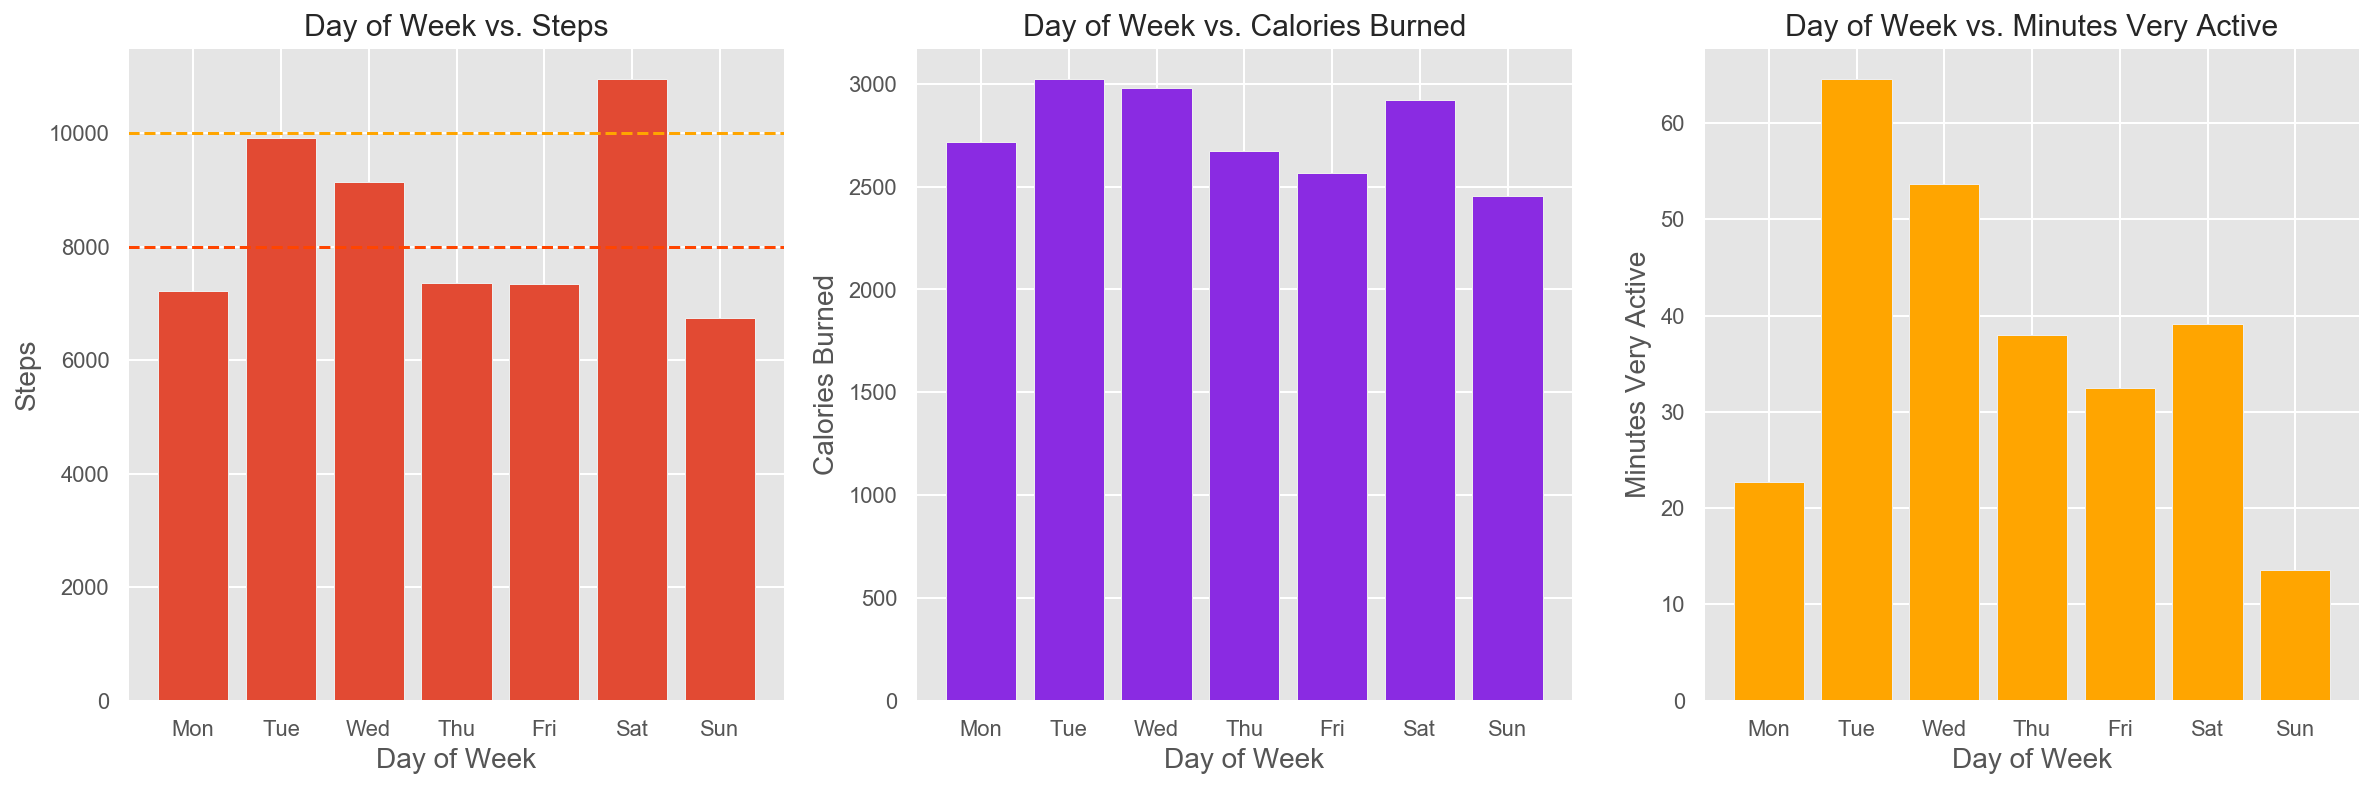

In [91]:
fig = plt.figure(figsize = (20,6))   #设置图形窗口 fig 为20*6
#在figure窗口中生成一行三列的子图，即一行生成三个图，这里先生成第一个图ax
ax = plt.subplot(131)   #使用plt.subplot()函数分割上面plt.figure()的图生成子图，即在一张大窗口生成多个子图，subplot(213)默认是在窗口里生成两行一列第三个子图，系统默认是(111)
plt.bar(dayGroupedData.index, dayGroupedData['Steps'])   #应该是(131)图像的【刻度】横坐标数据取自dayGroupedData，纵坐标数据取自数据类型是'Steps'的dayGroupedData，图像的颜色好像默认是红色
plt.title('Day of Week vs. Steps', fontsize=15)    #设置(131)图像的【标题为】'Day of Week vs. Steps'，字体大小设置为15
plt.xlabel('Day of Week', fontsize=14)             #设置(131)图像的【横坐标标签】为'Day of Week'，字体大小为14
plt.ylabel('Steps', fontsize=14)                   #设置(131)图像的【纵坐标标签】为'Steps'，字体大小为14
ax.axhline(8000, color="orangered", linestyle='--')   #应该是设置一条垂直于y轴的比较线，其值为8000，颜色是orangered_老橘黄色，线条风格使用“- -”
ax.axhline(10000, color="orange", linestyle='--')     #同上类似
ax.set_xticklabels(minDayCodes)                    #设置横坐标x轴【刻度标签】的标题数据取自minDayCodes

#############

ax2 = fig.add_subplot(132)                         #使用fig.add_subplot()函数连接上一个图，生成一行三列中的第二个子图  ax2
plt.bar(dayGroupedData.index, dayGroupedData['Calories Burned'], color='blueviolet')    #(132)图像横坐标【刻度】数据取自dayGroupedData,纵坐标数据取自数据类型为'Calories Burned'的dayGroupedData，图像颜色使用'blueviolet'
plt.title('Day of Week vs. Calories Burned', fontsize=15)     #(132)图像的【标题】设置为 Day of Week vs. Calories Burned 字体大小设置为15
plt.xlabel('Day of Week', fontsize=14)                        #【横坐标标签】名为 Day of Week 字体大小为14
plt.ylabel('Calories Burned', fontsize=14)                    #【纵坐标标签】名为 Calories Burned 字体大小为14
ax2.set_xticklabels(minDayCodes)                              #横坐标【刻度标签】的标题数据取自minDayCodes

#############

ax3 = fig.add_subplot(133)                         #使用fig.add_subplot()函数连接上一个图，生成一行三列中的第三个子图  ax3
ax3.set_xticklabels(minDayCodes)                   #设置(133)图像的横坐标【刻度标签】数据取自minDayCodes
plt.bar(dayGroupedData.index, dayGroupedData['Minutes Very Active'], color='orange')   #设置横坐标的【刻度】数据取自dayGroupedData,纵坐标数据取自数据类型是'Minutes Very Active'的dayGroupedData
plt.title('Day of Week vs. Minutes Very Active', fontsize=15)  #设置(133)图像标题为 Day of Week vs. Minutes Very Active，字体大小为15
plt.xlabel('Day of Week', fontsize=14)                         #设置横坐标【标签】名为 Day of Week 字体大小为14
plt.ylabel('Minutes Very Active', fontsize=14)                 #设置纵坐标【标签】名为 Minutes Very Active 字体大小为14
plt.show()                                                     #显示窗口

Not fussing on the daily calorie burn, I had kept a goal of attaining 8000 steps count each day on my Fitbit device. The graphs below suggested I am averaging about ~7800 steps per day which is a quite close to my goal. There are some studies which suggest hitting 10000 steps per day is ideal and that shall be the next target.

Tuesdays to Saturdays were the days where I averaged about 40 minutes of very active minutes - which simply translates to active exercise. Fewer minutes on Sundays were due to purely due to laziness/recovery time. The drop in active minutes on Mondays proves that I am falling for the Monday Blues and guess it's time to fix that 💪🏼

## 2. Sedentary minutes

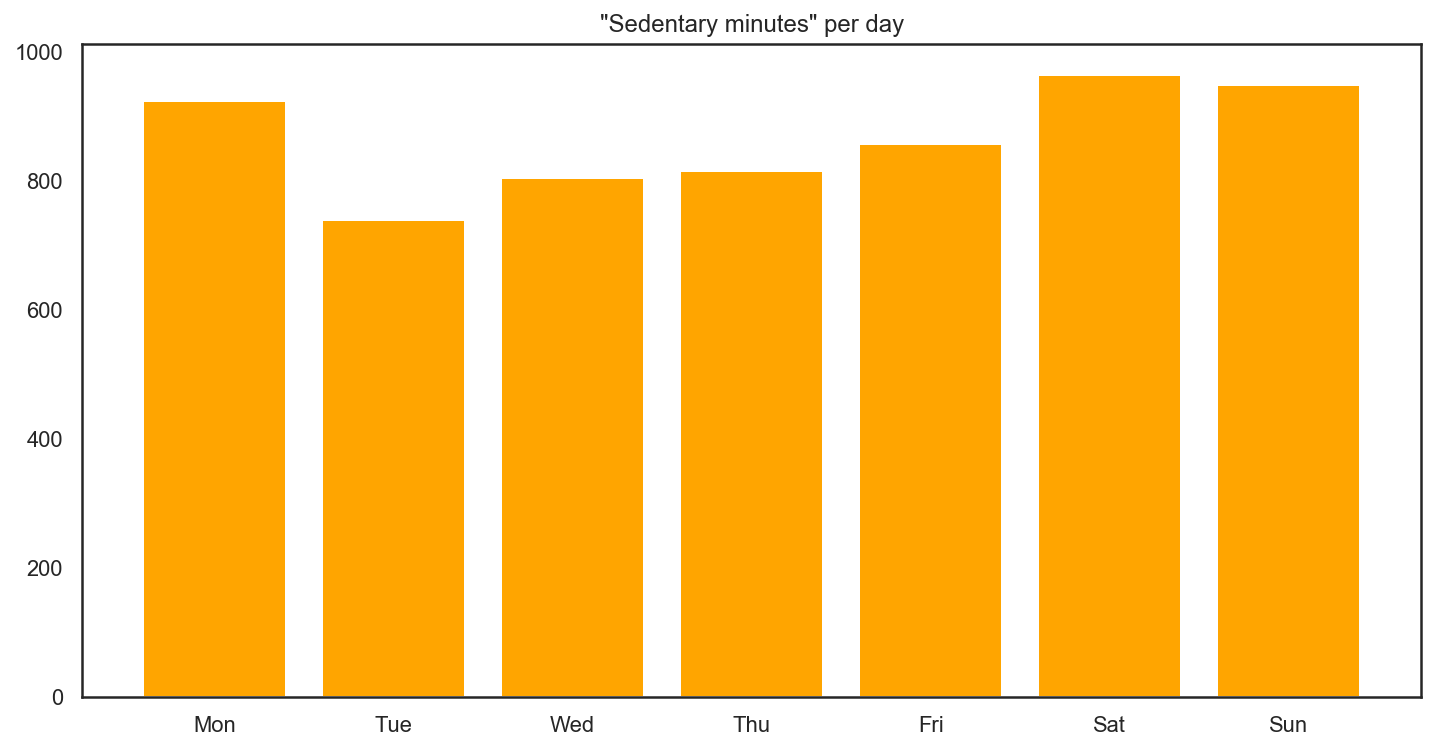

In [121]:
plt.bar(dayGroupedData.index, dayGroupedData['Minutes Sedentary'], color='orange', tick_label=minDayCodes[1:])   
      # 设置横坐标【刻度】数据取自dayGroupedData，纵坐标数据取自类型为Minutes Sedentary的dayGroupedData，图像颜色用 orange，刻度标签设置为minDayCodes里从1开始到最后一个数，即周一到周日
plt.title('"Sedentary minutes" per day')    
      # 设置标题为 "Sedentary minutes" per day
plt.show()

## Average heart rate / calorie burn rate per min / vs exercise type

Analysing the amount of calories burned per minutes for various Activities shows some interesting findings. Though there is a lot of similar data available on internet, it is very difficult to generalise these numbers for everyone. Since, lot of this depends on the fitness levels, demographics, skillset and most importantly how much I enjoy doing some specific exercises.

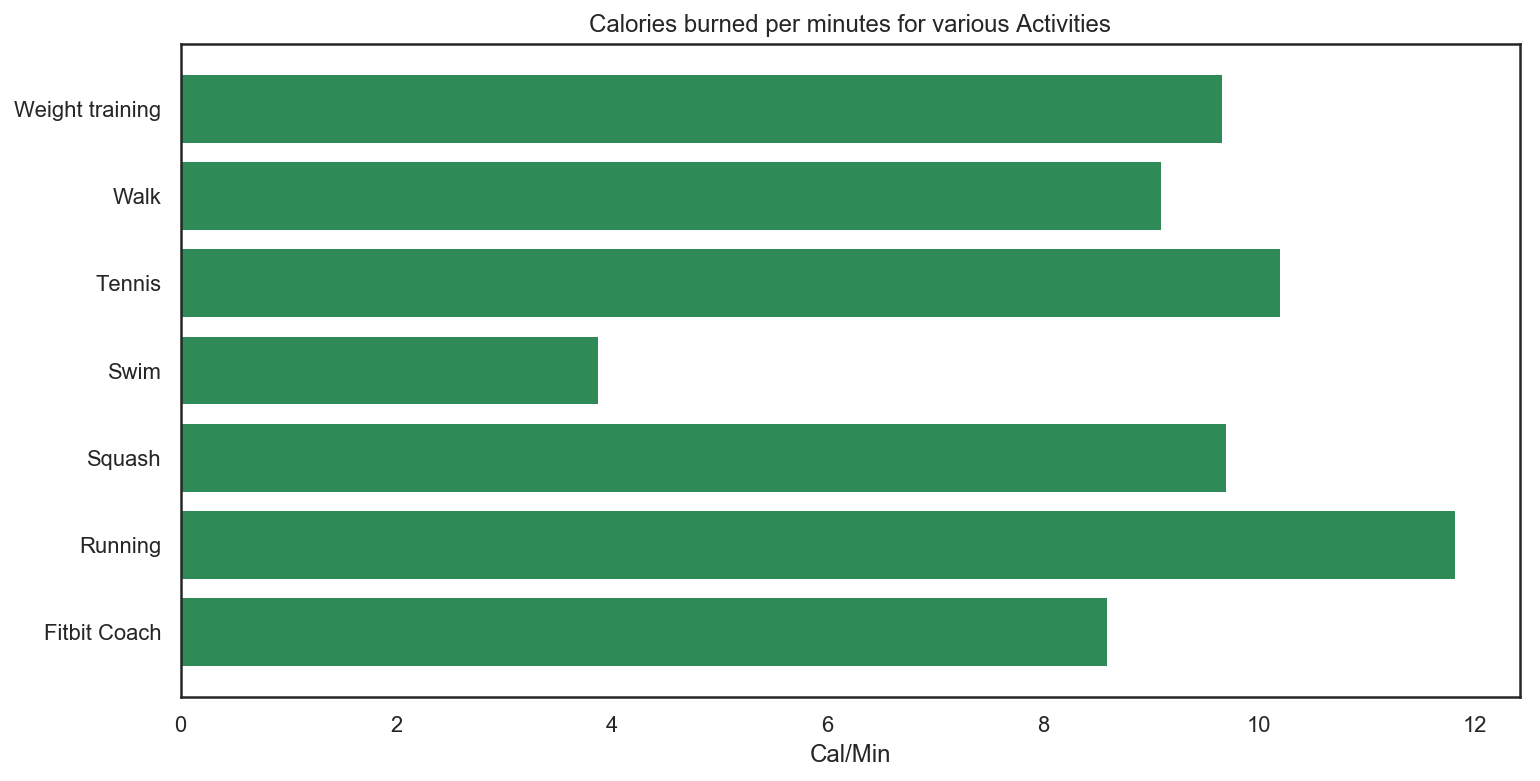

,Time,avgBPM,maxBPM,Calories burned,Steps,Cal/Min
Activity Type,,,,,,
Fitbit Coach,10.000000,131.0,149.0,86.000000,5.0,8.600000
Running,9.000000,149.0,183.0,107.000000,1202.0,11.825000
Squash,44.000000,139.0,170.0,427.000000,4366.0,9.704545
Swim,20.333333,0.0,0.0,77.666667,97.0,3.876400
Tennis,35.000000,144.0,176.0,357.000000,2507.0,10.200000
Walk,20.000000,121.0,164.0,182.000000,2239.0,9.100000
Weight training,21.000000,136.0,166.0,203.000000,100.0,9.666667


In [127]:
activityDf = pd.read_excel(filename2, sheet_name="activities")             #读取xecel2表里的activities类型数据
#skateboard,badminton, body weight ex, cyclinng    滑板，羽毛球，体重，自行车
activityDf['Cal/Min'] = activityDf['Calories burned']/activityDf['Time']   #定义一个新的变量 Cal/Min ,把 Calories burned / Time 赋值给它
groupedActivitiesDf = activityDf.groupby(['Activity Type']).mean()         #对数据类型为 Activity Type 的数据用groupby函数分组并计算平均值，类型是float64

#Plot Data
plt.barh(groupedActivitiesDf.index, groupedActivitiesDf['Cal/Min'], color='seagreen')    #创建横着的柱状图barh，与竖着的柱状图bar方向不同。
   #groupedActivitiesDF表的行数据做barh的纵坐标值，类型为 Cal/Min 的groupedActivitiesDF数据做横坐标值，图像使用颜色为 seagreen
plt.title('Calories burned per minutes for various Activities')   #设置图像的标题为 Calories burned per minutes for various Activities
plt.xlabel('Cal/Min')   #设置图像横坐标【标签】名为 Cal/Min

plt.show()              #作图
groupedActivitiesDf     #显示groupedActivitiesDF表信息


It is interesting to see that running helps me burn almost 12 calories per minute. The maths is simple, to compensate for a beer, a 10 minutes runs is what I need. 🏃🏻‍+ 🕑 = 🍺

Tennis 🎾 - the favourite activity from the lot - takes the second spot. That's again a win-win scenario! It will be interesting to see if this number changes as I improve my skills.

Swimming numbers were not shocking to me because I am still struggling to keep up with my continuous lap count. And after spending some time in pool, the exercise turns to a leisure activity.

Point to note here is that calories burned should not be the only metric on which these activities can be graded. But, this happens to be the only metric which I can currently measure via Fitbit.

## 3. Calorie burn coorelation

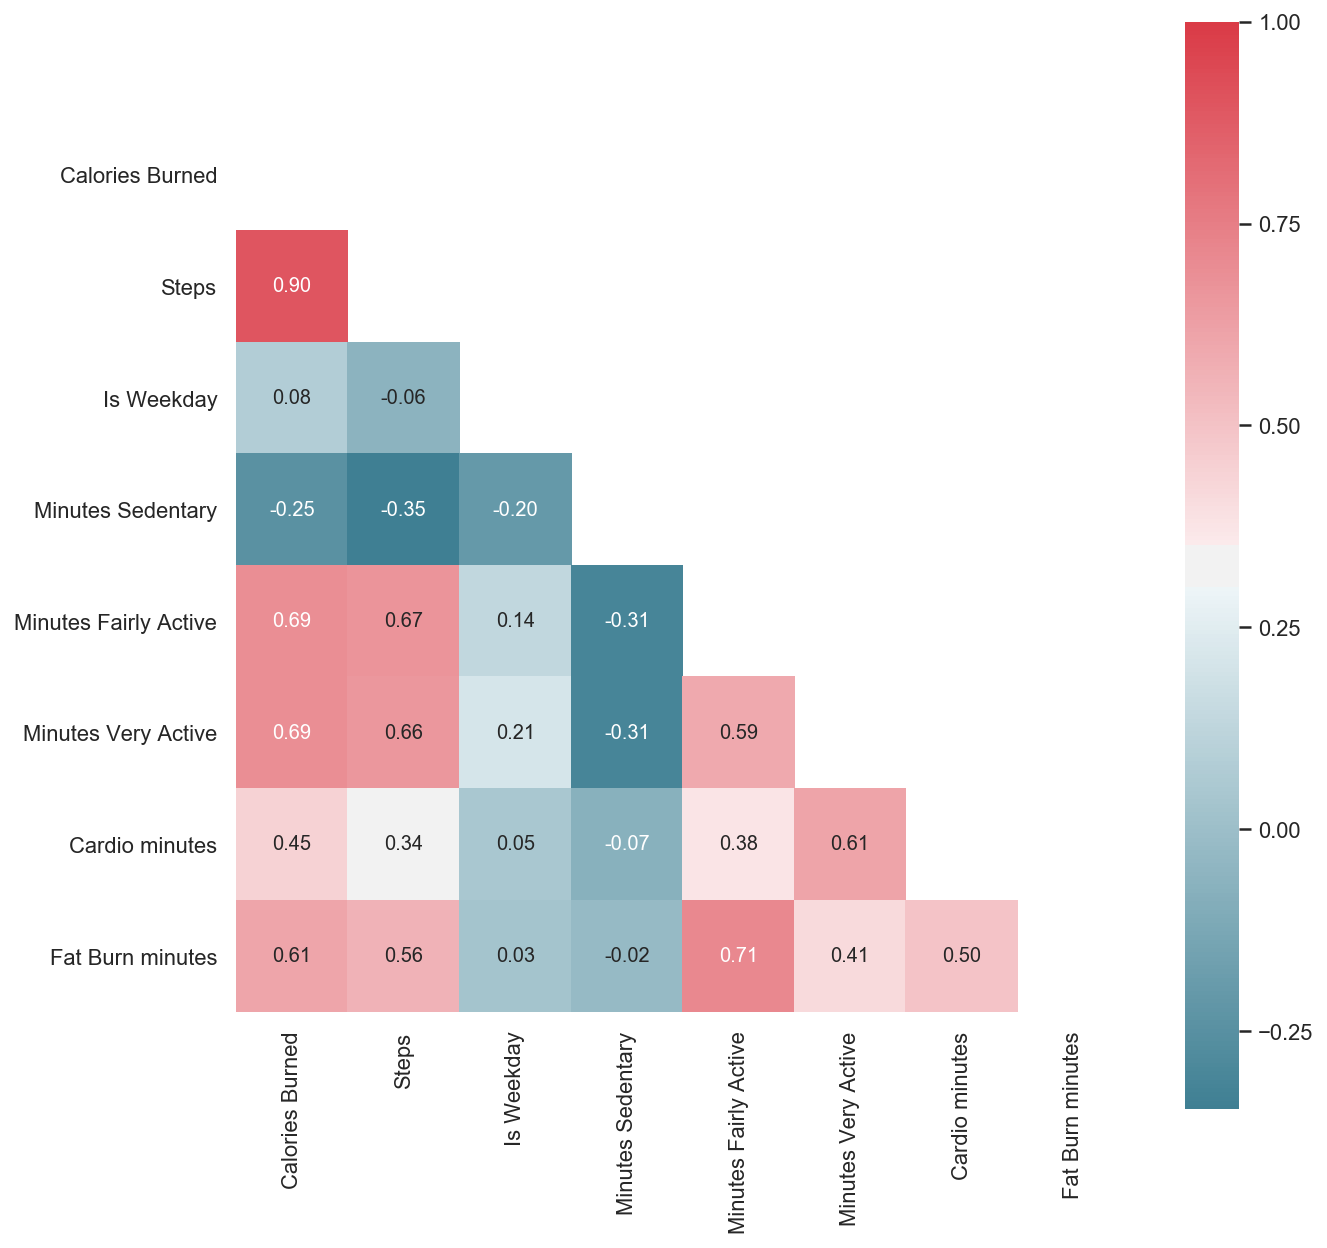

In [123]:
#设置correlationOf(符合关系)为Calories Burned
correlationOf = 'Calories Burned'    
#设置corrdf_calories(符合卡路里)的数据为data中的各项
corrdf_calories = data[['Calories Burned','Steps', 'Is Weekday', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Cardio minutes', 'Fat Burn minutes']]
#绘制热力图，对corrdf_calories使用corr()函数，该方法用来计算DataFrame对象中所有列之间的相关系数，该热力图反应的是 correlationOf,  ''单引号应该是默认主题不是黑色主题
plot_heatmap(corrdf_calories.corr(), correlationOf, '')

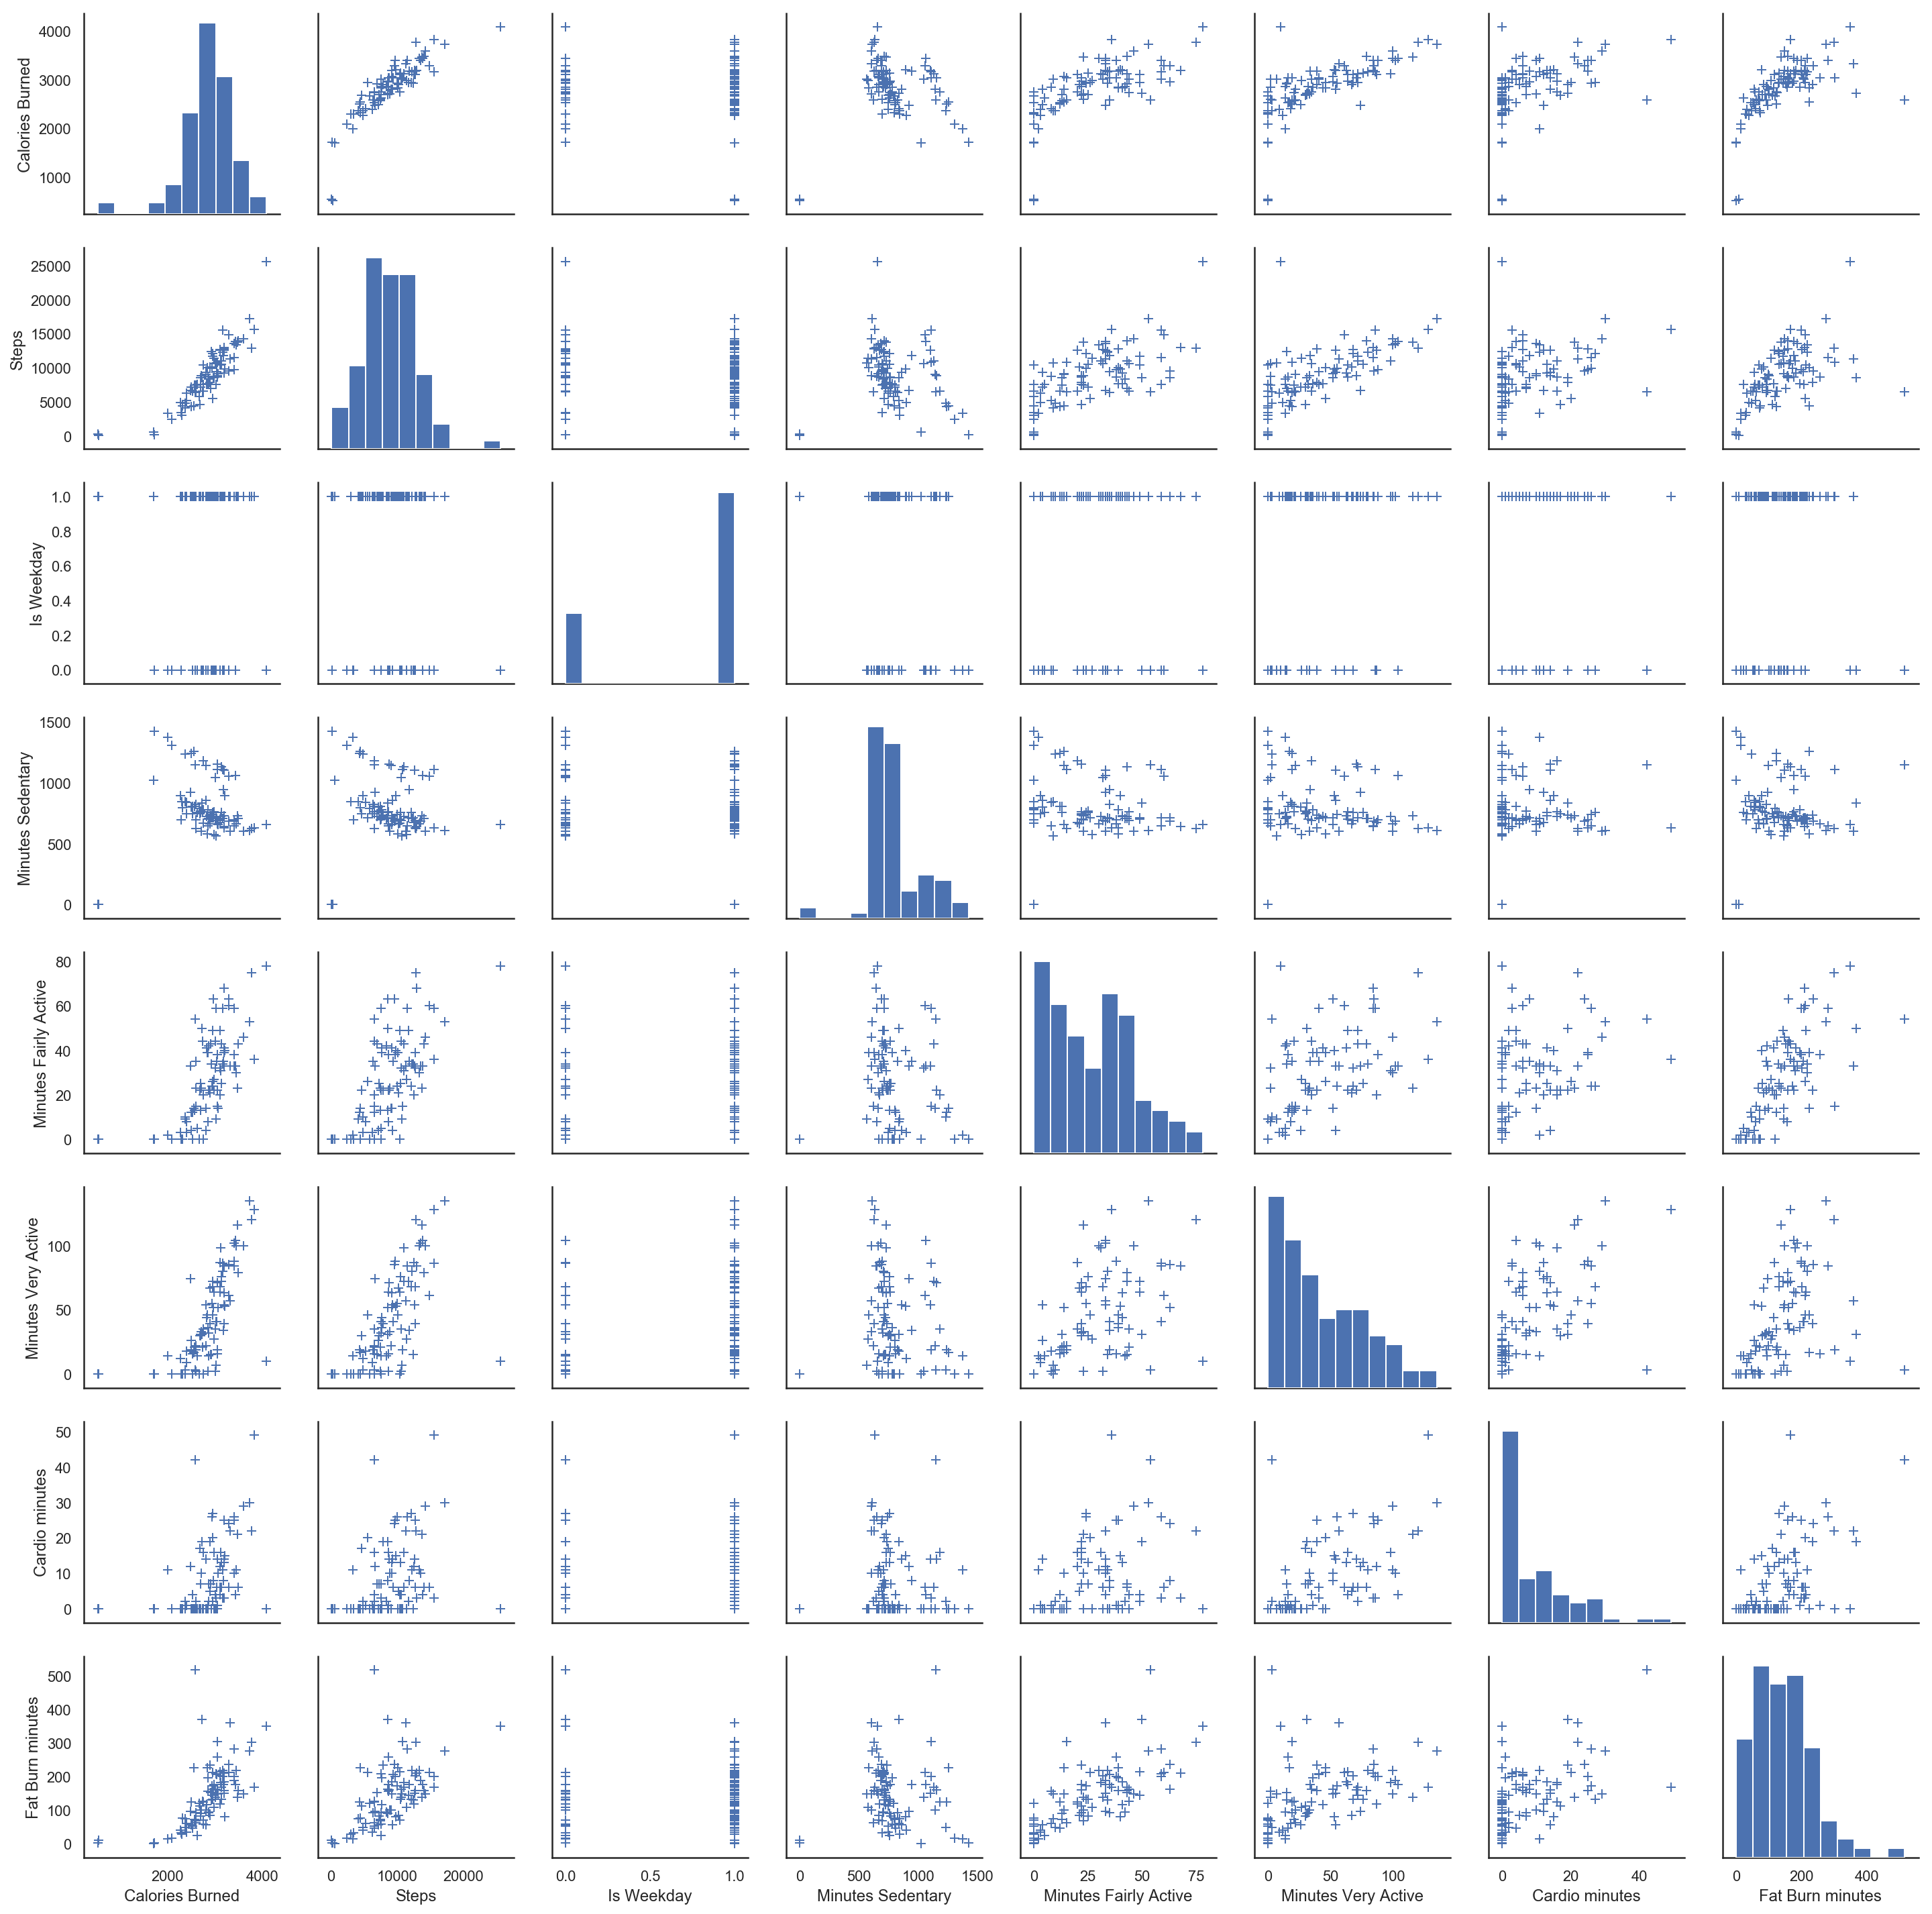

In [95]:
# Basic correlogram
#使用dropna()函数删除缺失数据，kind类型设置为散点图，markers绘图所用点形状设置为 +（加号）
#绘制子图数字字典，s=50，点数取50个，edgecolor（边缘颜色）取蓝色，（线条宽度）
sns.pairplot(corrdf_calories.dropna(), kind="scatter", markers="+", plot_kws=dict(s=50, edgecolor="b", linewidth=1))
plt.show()

The calories burned is strongly related to amount of steps and active minutes. Minutes sedentary has a negative correlation with Weekdays which implies that I spend more time slacking off on weekends.

---
# Sleep Analysis

Sleep is essential to helping maintain mood, memory, and cognitive performance and there is no running from it. We spend about a third of our life in sleeping. That's a staggering 26 years spent sleeping in bed! While metabolism generally slows down, all major organs and regulatory systems continue to function. Hence, it becomes important to get the most out of our sleep.

Reading more on this, I found that there are some standard ways which can help achieve a good night sleep.
* Following a good sleep schedule
* Avoid bright/blue light at night before hitting the bed
* Avoid caffeine later in the day
* Sleep in a cool and dark room
* Getting at-least 7–9 hours of sleep. There are some studies which say that even in 5 hours you can achieve the most out of your sleep.

Over the course of this experiment, I tried to follow the above steps to bind myself to a strict sleep schedule. It was time to validate them.

## 1. How regular is my sleeping habits?

 - Am I getting the required hours of sleep? - Average sleep hours and the deviation
 - Am I following a good sleep schedule? - Average sleep and wake up timings

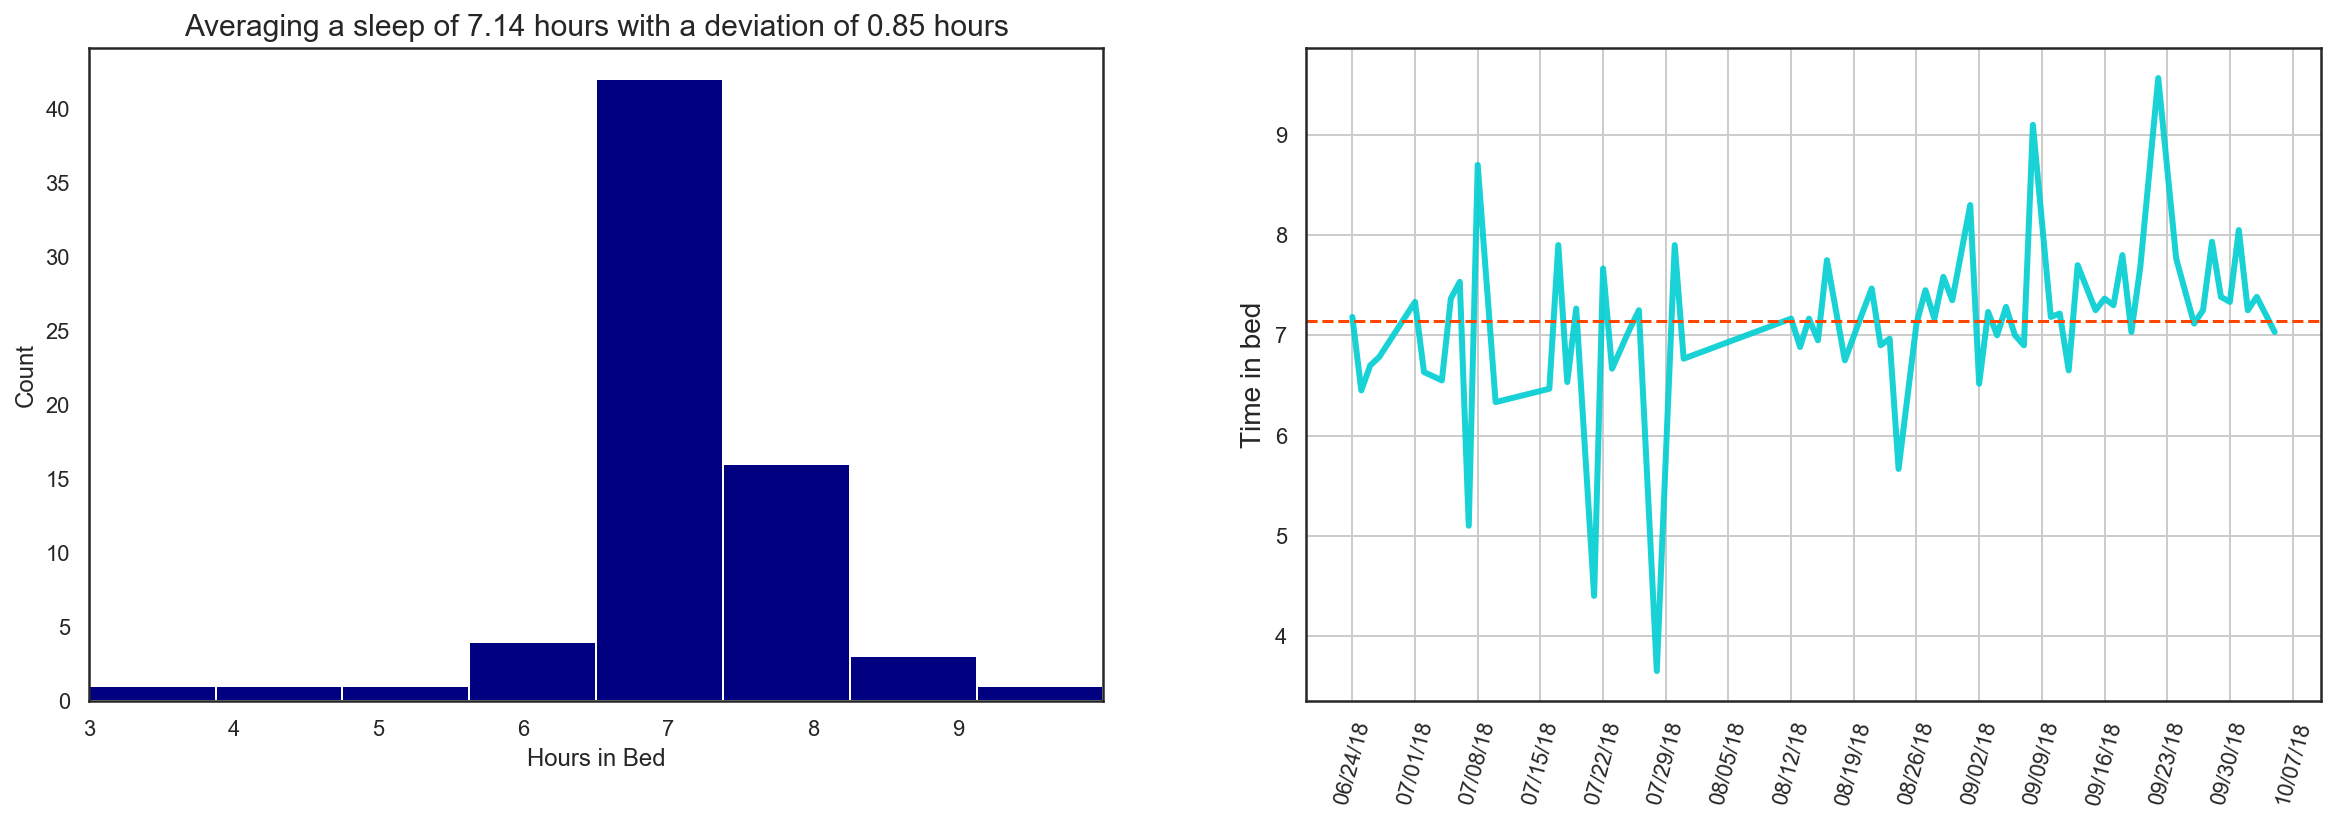

,count,mean,std,min,25%,50%,75%,max
Time in bed,69.0,7.135507,0.854013,3.65,6.883333,7.216667,7.45,9.566667


In [136]:
import matplotlib.dates as mdates    #使用matplotlib.dates库 用于年月日 小时分，画图，即画刻度是时间轴图
#使用describe()函数对DataFrame中的sleepData中的Time in bed类型数据除以60后进行操作，括号内不写内容是默认计算数据的count（非空数值的个数），
#mean(平均值)，std(???),min,25%,50%,75%,max,dtype:float64;
#使用transpose() 函数是对数据(如矩阵)进行转置、旋转。
sleepDesc = pd.DataFrame(sleepData['Time in bed']/60).describe().transpose()   
avgSleepHours = round(sleepDesc.at['Time in bed','mean'],2)   #对 Time in bed 和 mean 使用round() 方法返回浮点数x的四舍五入值
#定义新变量summary（准备做图像标题）并赋值
summary = 'Averaging a sleep of {} hours with a deviation of {} hours'.format(avgSleepHours, round(sleepDesc.at['Time in bed','std'],2))
hoursInBed = sleepData['Time in bed']/60   #给定义新变量hoursInBed，（准备做图像纵坐标）把 Time in bed / 60赋值给它

fig = plt.figure(figsize = (20,6))                                  #绘制窗口20*6

ax = plt.subplot(121)                                               #绘制一行两列第一个图像 ax              
plt.hist(hoursInBed, bins = 8, range = (3, 10), color="navy")       #使用hist()函数绘制直方图括号里（hoursInBed这个参数是指定每个bin(箱子)分布的数据,对应x轴）
                   #bins 指出直方图条数，range（3，10）创建一个整数列表，从3到10的一维矩阵，图像颜色用navy（深蓝色）
plt.xlim(3, 10)   #设置x轴参数范围
plt.xticks(range(3, 10))            #x轴【标题】设置为用range()函数构成的3到10的一维矩阵
plt.xlabel('Hours in Bed')          #X轴【标签】名字叫 Hours in Bed
plt.ylabel('Count');                #Y轴【标签】名字叫Count      
plt.title(summary, fontsize=15)     #设置图像【标题】

#############

ax2 = fig.add_subplot(122)          #设置一行两列第二个窗口 ax2 并连接上一个图
plt.plot(sleepData['Date'],hoursInBed, linestyle='-',      #使用plot()函数绘制图像，Date类型sleepData做x轴，hoursInBed做y轴，线条风格用‘-’
         #标记大小设置成10，颜色设置为暗蓝绿色，标签为 % Light ，线宽为3.0，透明度设置为0.9
         markersize=10, color='darkturquoise', label='% Light', linewidth=3.0, alpha=0.9)
plt.ylabel('Time in bed', fontsize=14)      #设置y轴标签为 Time in bed ，大小为14
ax2.axhline(avgSleepHours, color="orangered", linestyle='--')       #使用axhline()函数设置垂直y轴的线，值为avgSleepHours，颜色为老橘色，线条风格是- -
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=6))     #可能是设置坐标类型吧
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%D'))           #可能是设置坐标类型吧
ax2.grid(True)                                                      #设置一个控件（按钮什么的）
plt.xticks(rotation=75)                                             #设置x标题旋转75
plt.plot()                                                          #绘制图像

plt.show()
sleepDesc


As far as behavioral data goes, this is reasonably well-behaved. Notice that this distribution doesn't vary much and is quite steep. The deviation is of less than an hour.

On the other note, according to [National Sleep Foundation](https://www.sleepfoundation.org/how-sleep-works/how-much-sleep-do-we-really-need/page/0/2) I should be getting sleep between 7-9 hours. Looks like barely scratching the mark here! 😅

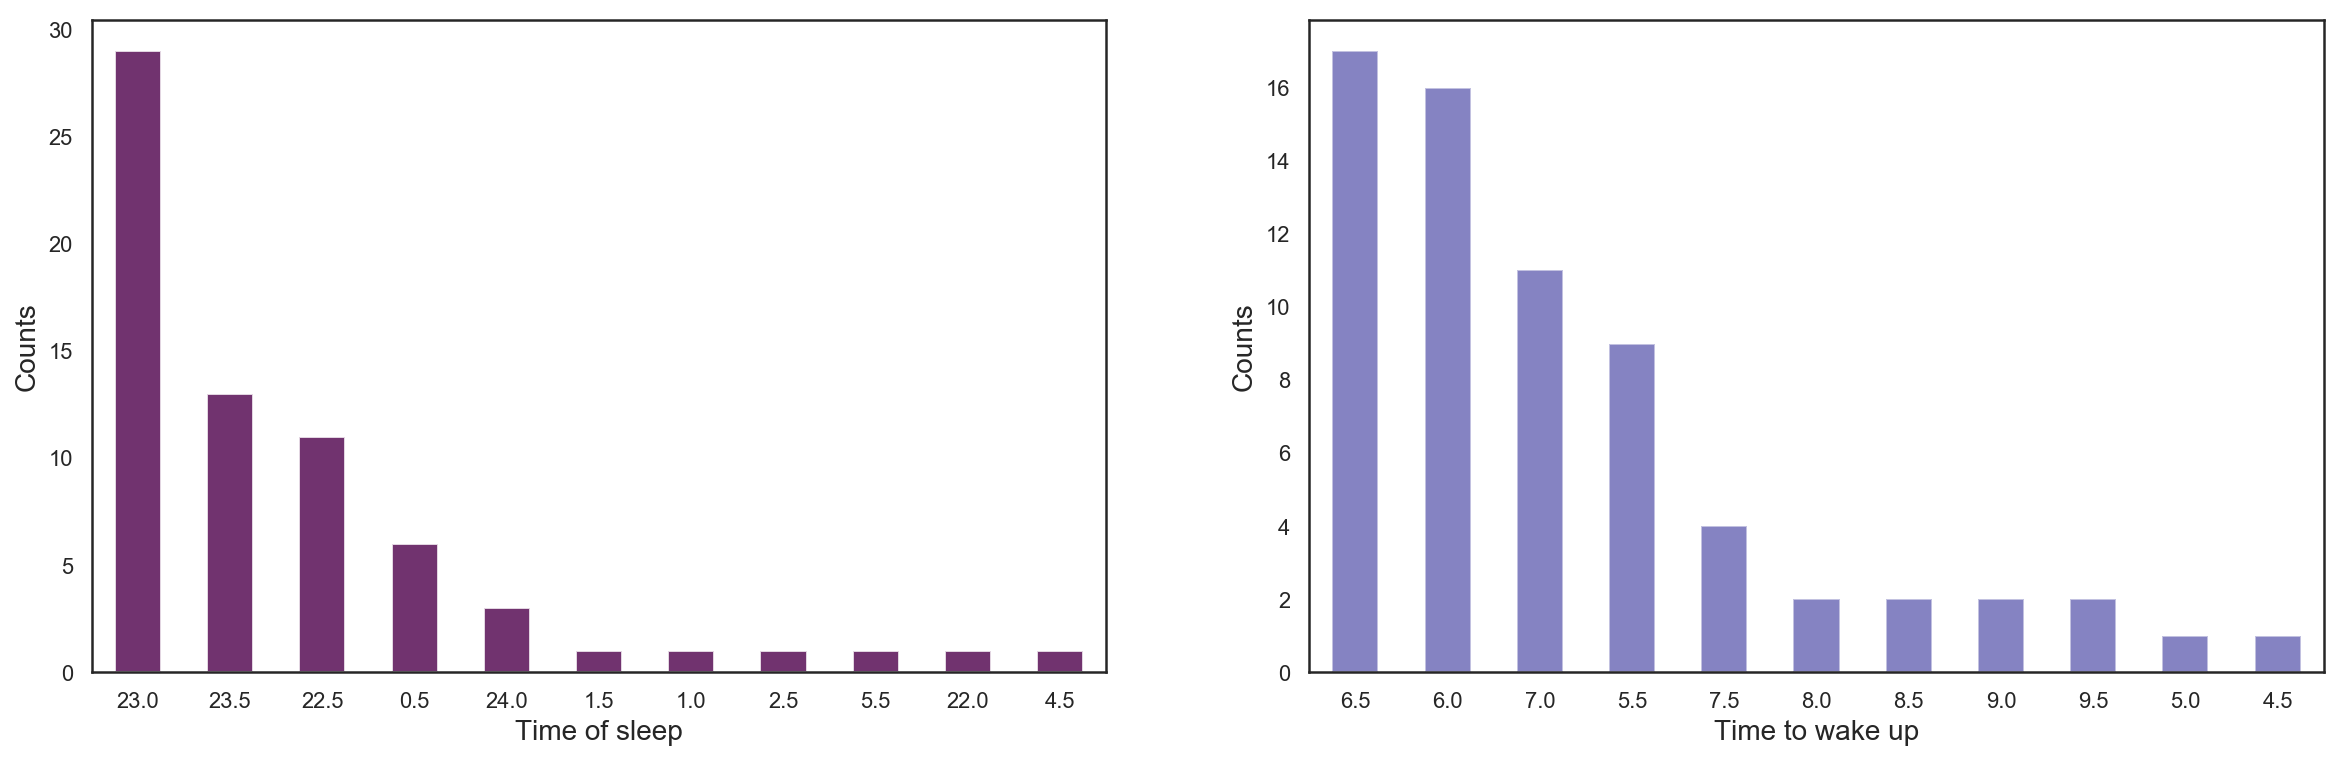

In [129]:
sleepBDF = sleepData[['Sleep Bucket', 'Awake Bucket', 'Time in bed']]   #定义变量sleepBDF，把sleepData的['Sleep Bucket', 'Awake Bucket', 'Time in bed']赋值给它
sleepBDF['Time in bed'] = sleepBDF['Time in bed']/60                    #把 sleepBDF['Time in bed']/60 赋值给 sleepBDF['Time in bed']

#sleepBDF.groupby(['Sleep Bucket']).mean()
#sleepBDF.describe().transpose()

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))             #创建窗口20*6

ax = plt.subplot(121)                          #绘制一行两列第一个图像 ax
pd.value_counts(sleepData['Sleep Bucket']).plot.bar(cmap="BuPu_r", alpha=0.8)     #图像取值于Sleep Bucket类型的sleepData，绘制条形图括号里cmap应该是颜色类别是蓝紫色，不透明度为0.8，
plt.xlabel('Time of sleep', fontsize=14)       #设置x轴【标签】为Time of sleep，大小为14
plt.ylabel('Counts', fontsize=14)              #设置y轴【标签】为Counts，大小为14
plt.xticks(rotation=0)                         #设置x轴标题旋转程度为0
 
#############

ax2 = fig.add_subplot(122)                     #绘制一行两列第二个图像 ax2
pd.value_counts(sleepData['Awake Bucket']).plot.bar(cmap="plasma", alpha=0.5)   #图像取值于Awake Bucket类型的sleepData，绘制条形图括号里cmap应该是颜色类别是plasma，不透明度为0.5，
plt.xlabel('Time to wake up', fontsize=14)     #设置x轴【标签】为Time to wake up，大小为14
plt.ylabel('Counts', fontsize=14)              #设置y轴【标签】为Counts，大小为14
plt.xticks(rotation=0)                         #设置x轴标题旋转程度为0
plt.show()                                     #绘制图像

#https://www.sleepfoundation.org/sleep-tools-tips/healthy-sleep-tips

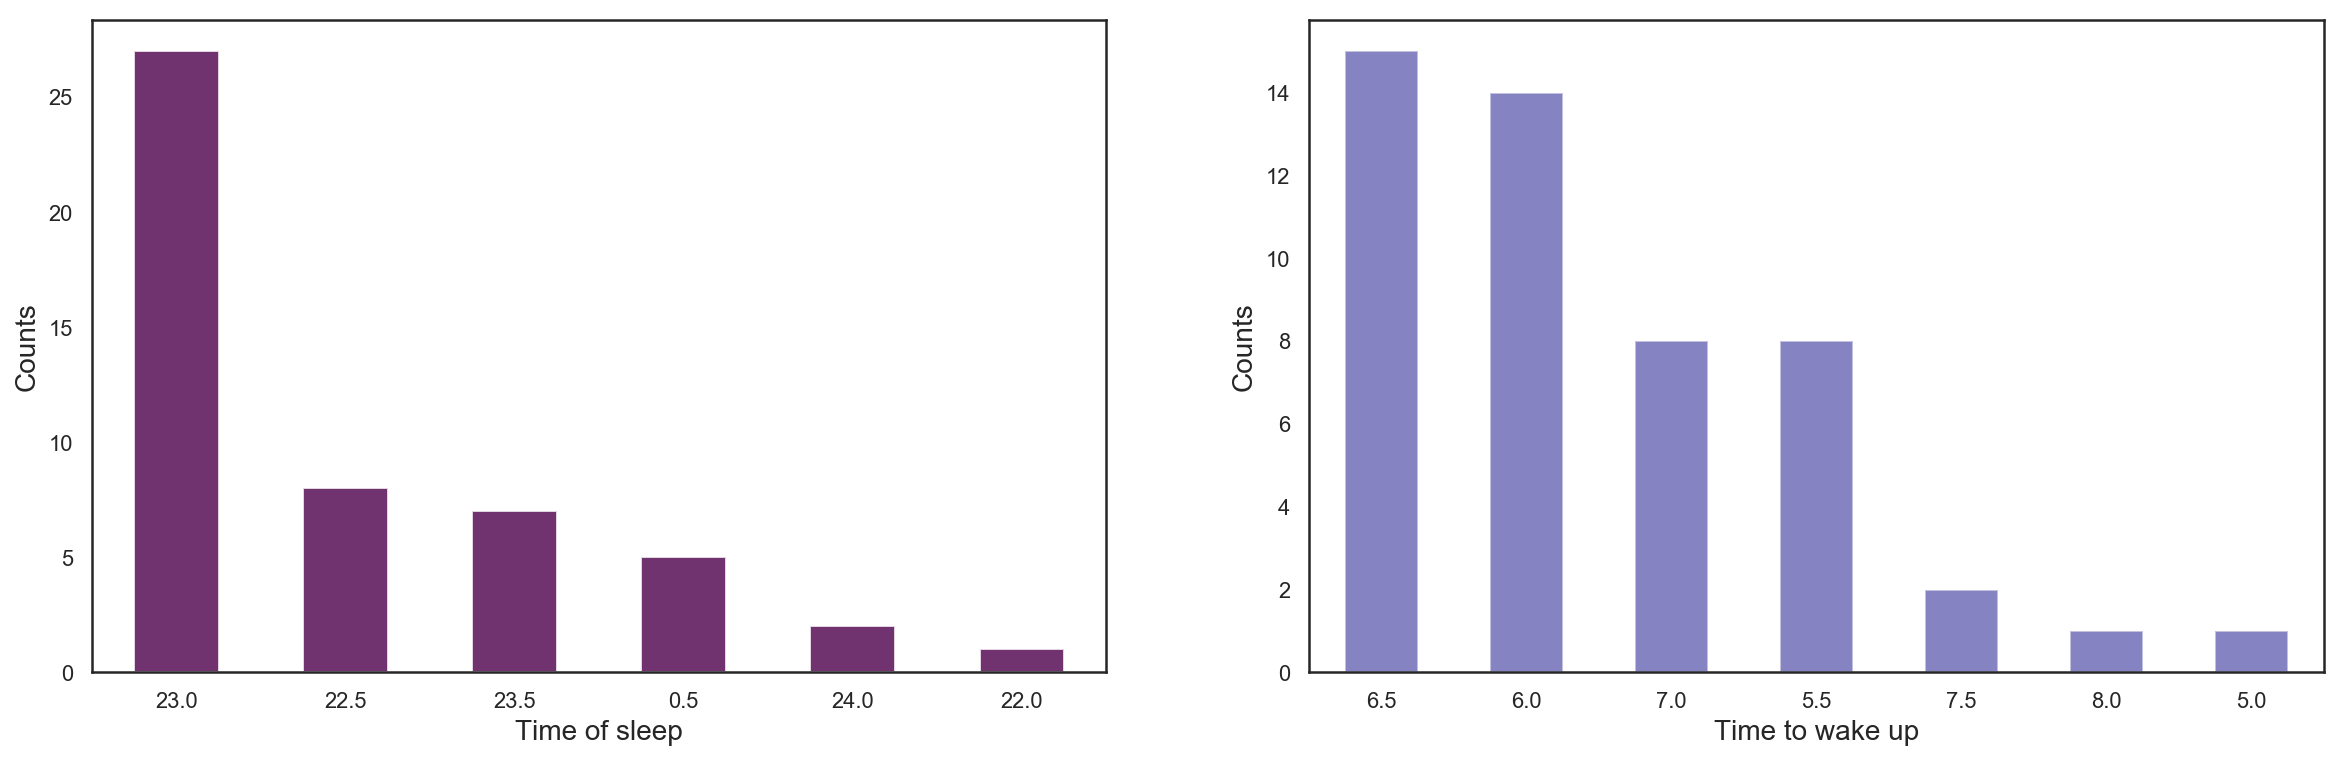

In [98]:
sleepBDF_weekday = sleepData[['Sleep Bucket', 'Awake Bucket', 'Time in bed', 'Is Weekday']]   #定义变量sleepBDF_weekday，并赋值
sleepBDF_weekday['Time in bed'] = sleepBDF_weekday['Time in bed']/60         #修改sleepBDF_weekday['Time in bed']对其除以60
sleepBDF_weekday = sleepBDF_weekday[sleepBDF_weekday['Is Weekday']]          #？？？

#sleepBDF.groupby(['Sleep Bucket']).mean()
#sleepBDF.describe().transpose()

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))                     #创建窗口20*6

ax = plt.subplot(121)                                  #绘制一行两列第一个图像 ax
pd.value_counts(sleepBDF_weekday['Sleep Bucket']).plot.bar(cmap="BuPu_r", alpha=0.8) #图像数值取自sleepBDF_weekday['Sleep Bucket']，绘制条形图，颜色用蓝紫色，不透明度为0.8
plt.xlabel('Time of sleep', fontsize=14)               #设置x轴标签为Time of sleep，大小为14
plt.ylabel('Counts', fontsize=14)                      #设置y轴标签为Counts，大小为14
plt.xticks(rotation=0)                                 #设置x轴旋转程度为0

#############

ax2 = fig.add_subplot(122)                             #绘制一行两列第二个图像 ax2
pd.value_counts(sleepBDF_weekday['Awake Bucket']).plot.bar(cmap="plasma", alpha=0.5)   #图像取自sleepBDF_weekday['Awake Bucket']，绘制条形图，颜色用plasma，不透明度为0.5
plt.xlabel('Time to wake up', fontsize=14)             #设置x轴标签为Time to wake up，大小为14
plt.ylabel('Counts', fontsize=14)                      #设置y轴标签为Counts，大小为14
plt.xticks(rotation=0)                                 #设置x轴旋转程度为0
plt.show()                                             #绘制图像

#https://www.sleepfoundation.org/sleep-tools-tips/healthy-sleep-tips

## 2. Types of sleep

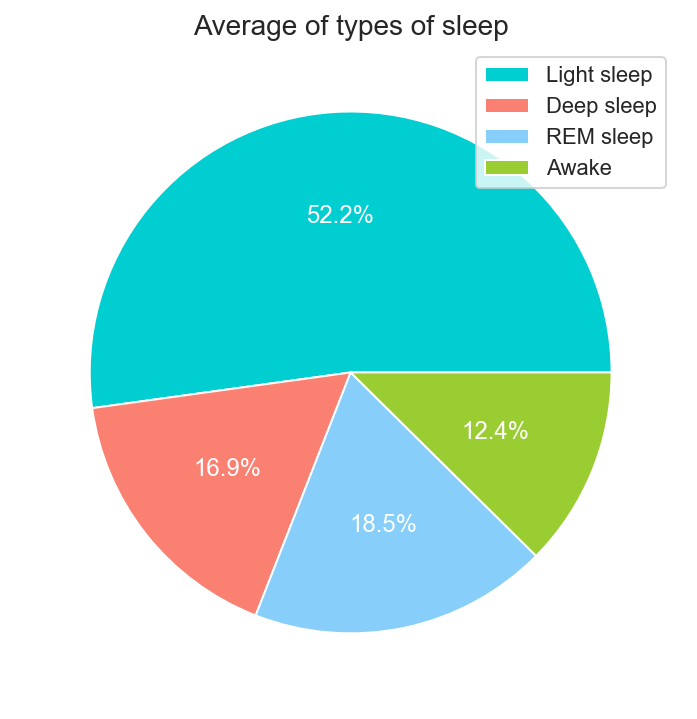

In [99]:
#定义变量acgSleep，并对其四个数据求平均值后赋值
avgSleep = sleepData[['Minutes Light sleep', 'Minutes Deep sleep', 'Minutes REM sleep', 'Minutes Awake']].mean() 

fig = plt.figure(figsize = (6,6))    #创建窗口6*6
labels=['Light sleep', 'Deep sleep', 'REM sleep', 'Awake']    #设置四个标签 
#绘制pie（饼图），数据取自avgSleep，颜色用darkturquoise', 'salmon', 'lightskyblue', 'yellowgreen，
# autopct 是控制饼图内百分比设置,可以使用format字符串或者format function   '%1.1f'   指小数点前后位数(没有用空格补齐)
#labels(每一块)饼图外侧显示的说明文字，texprops是文本设置，设置字典颜色为白色
plt.pie(avgSleep, colors = ['darkturquoise', 'salmon', 'lightskyblue', 'yellowgreen'], autopct='%1.1f%%', labels=labels, textprops=dict(color="w"))

# #carve the donut
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# p=plt.gcf()
# p.gca().add_artist(my_circle)

plt.title('Average of types of sleep', fontsize=14)          #设置标题为Average of types of sleep，大小为14
plt.legend()                                                 #使用legend()函数显示标签
plt.show()                                                   #显示图像

The plot below shows that on an average, my body spends just about 17% in Deep sleep, 19% REM and rest in either light or being slightly awake. The datetime plot of Light and Deep sleep shows that these numbers vary a lot.

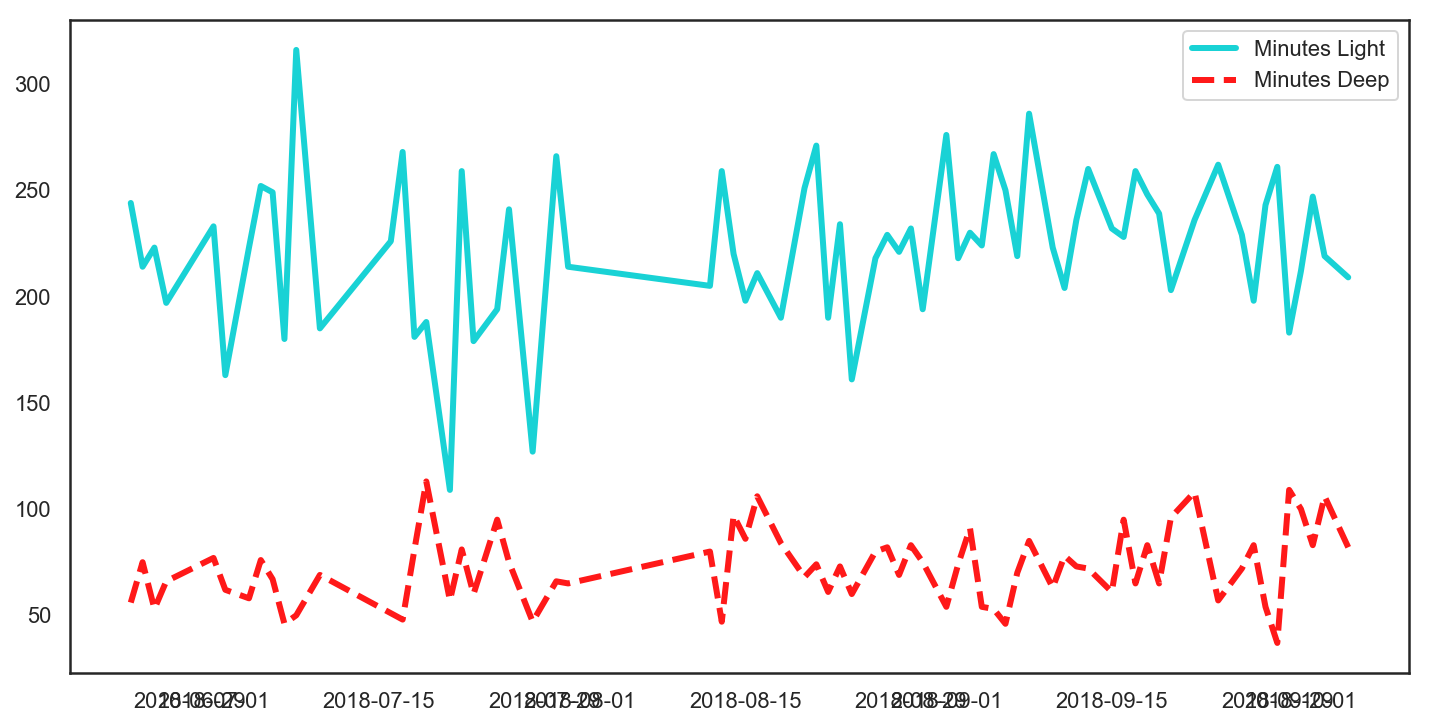

In [137]:
#绘制图像中x轴数据取自sleepData['Date']，y轴数据取自sleepData['Minutes Light sleep']，线条风格为 -
plt.plot(sleepData['Date'],sleepData['Minutes Light sleep'], linestyle='-',    
         #线条大小为10，颜色是深蓝青色，标签是'Minutes Light'，线宽是3.0，不透明度是0.9
         markersize=10, color='darkturquoise', label='Minutes Light', linewidth=3.0, alpha=0.9)
#绘制图像中x轴数据取自sleepData['Date']，y轴数据取自sleepData['Minutes Deep sleep']，线条风格为 - -
plt.plot(sleepData['Date'],sleepData['Minutes Deep sleep'], linestyle='--', 
         #线条大小为10，颜色是红色，标签是'Minutes Deep'，线宽是3.0，不透明度是0.9
         markersize=10, color='red', label='Minutes Deep', linewidth=3.0, alpha=0.9)
plt.legend()   #显示标签
plt.show()

## 3. Correlation between amount of sleep and the sleep stages.
Do sleeping more will help me attain more deep or REM sleep?

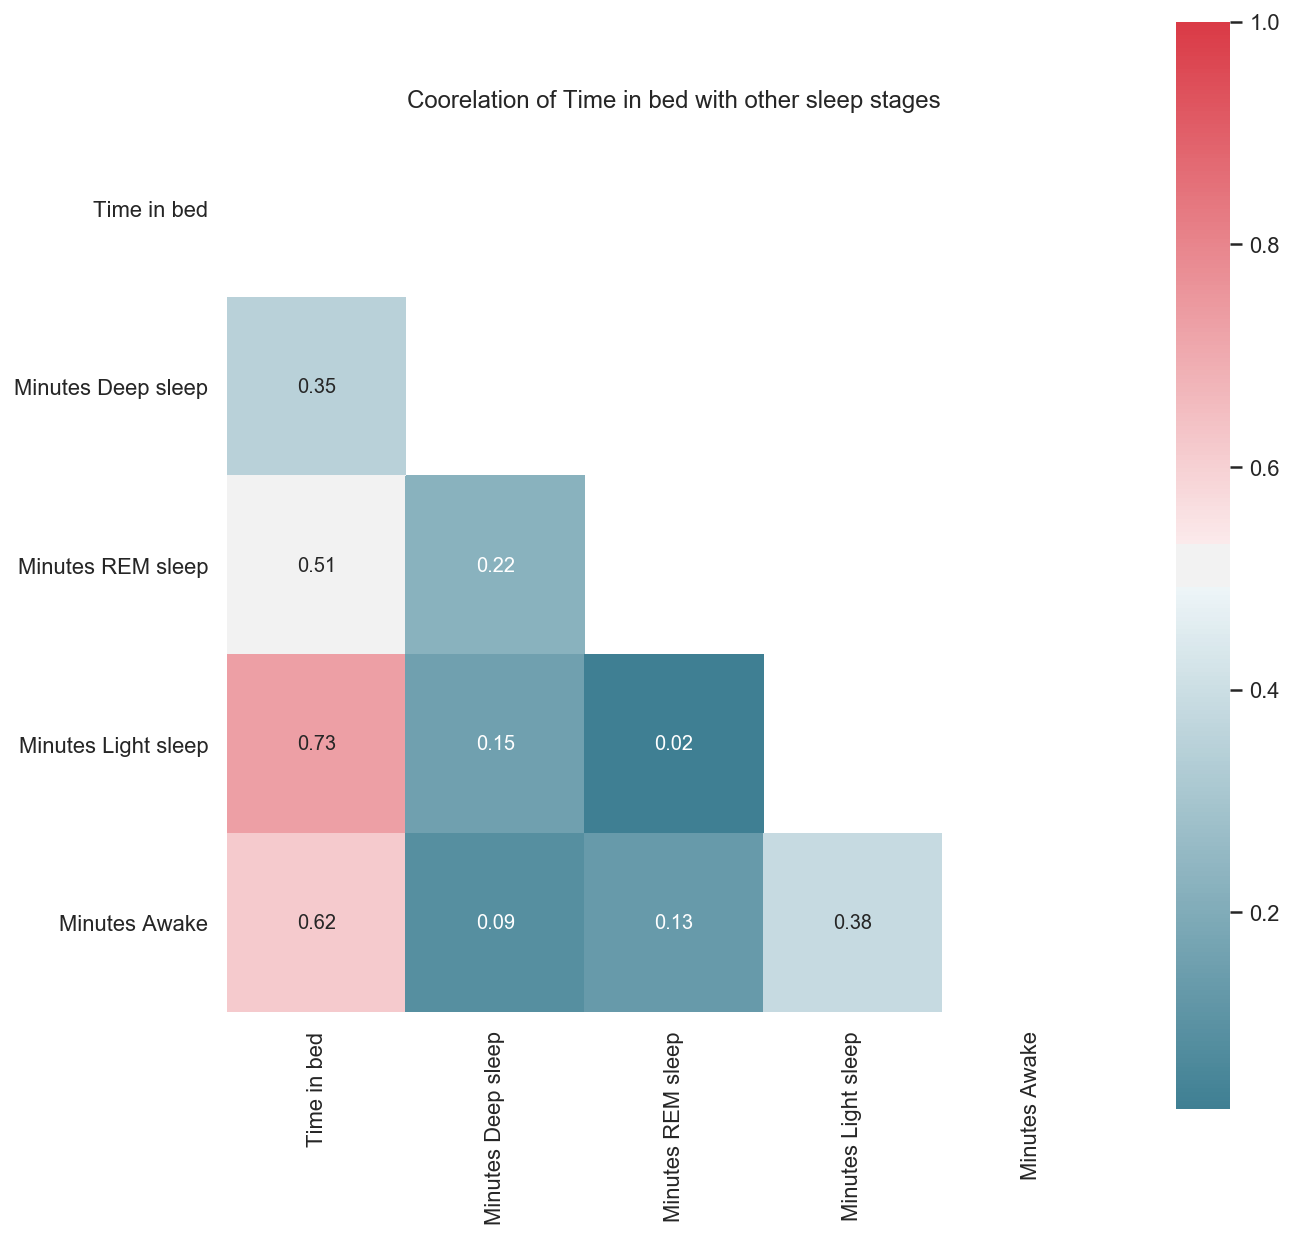

,Time in bed,Minutes Deep sleep,Minutes REM sleep,Minutes Light sleep,Minutes Awake
Time in bed,1.000000,0.349234,0.508851,0.732046,0.616285
Minutes Deep sleep,0.349234,1.000000,0.222683,0.153331,0.088011
Minutes REM sleep,0.508851,0.222683,1.000000,0.023480,0.130498
Minutes Light sleep,0.732046,0.153331,0.023480,1.000000,0.384258
Minutes Awake,0.616285,0.088011,0.130498,0.384258,1.000000


In [138]:
#定义变量corrdf_sleep_types  使用corr()函数求数据的关系，使用abs()函数取所有数据的绝对值
corrdf_sleep_types = sleepData[['Time in bed', 'Minutes Deep sleep', 'Minutes REM sleep', 'Minutes Light sleep', 'Minutes Awake']].corr().abs()
#绘制热力图，数据取自corrdf_sleep_types，关系是correlationOf，标题是 Coorelation of Time in bed with other sleep stages
plot_heatmap(corrdf_sleep_types, correlationOf, 'Coorelation of Time in bed with other sleep stages')
corrdf_sleep_types #显示表格数据

Notice that the "Deep sleep minutes" are not very coorelated with the time in bed. 
Which shows that sleepinng more doesn't necessarily guarantee a good deep sleep.

## 4. Types of Sleep based on different days

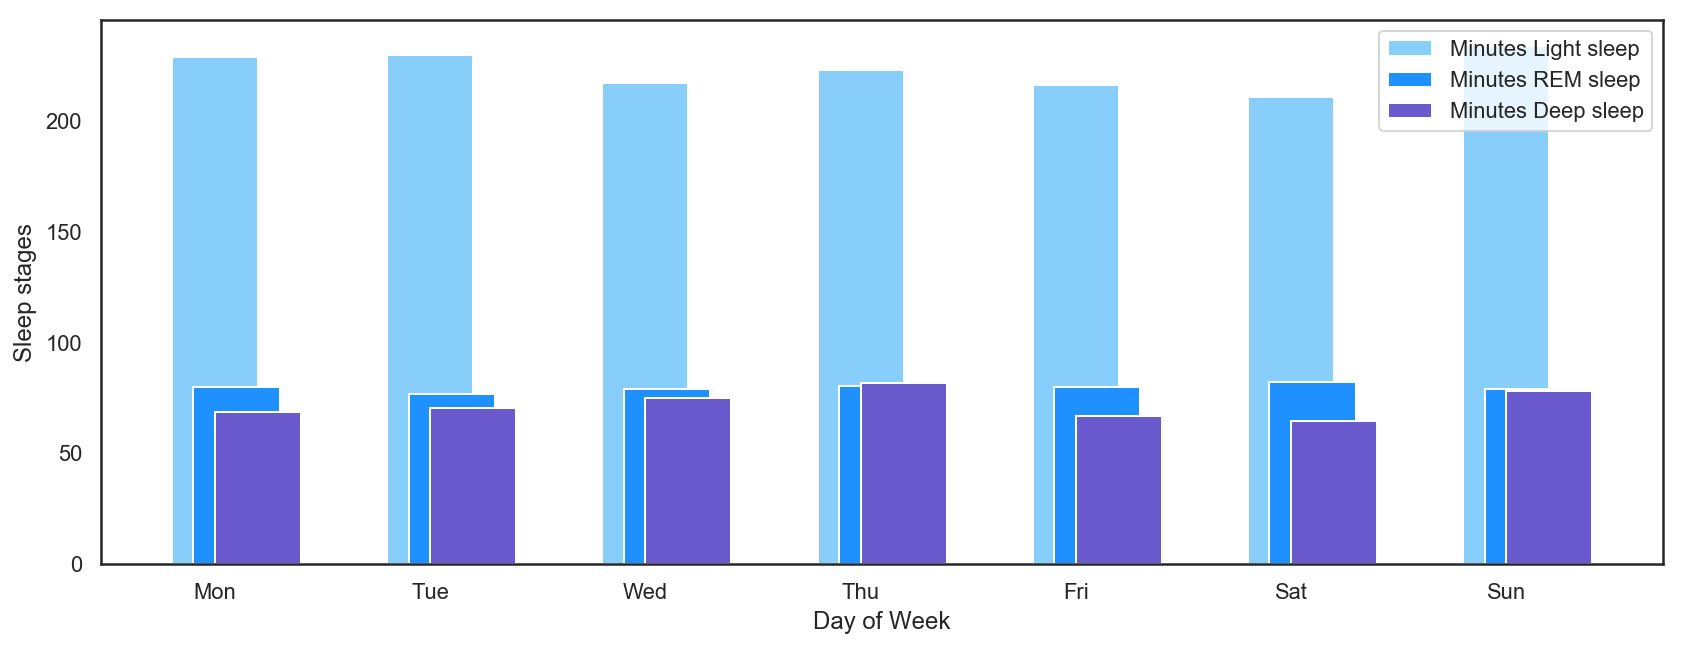

In [141]:
fig = plt.figure(figsize = (14,5))    #创建窗口14*5
#绘制条形，窗口中条形设置行位置 ，数据取自dayGroupedData['Minutes Light sleep']，条形宽度0.4，颜色lightskyblue，标签是Minutes Light sleep，横坐标标题标签取自minDayCodes中从1到最后
plt.bar((dayGroupedData.index), dayGroupedData['Minutes Light sleep'],width = 0.4, color='lightskyblue', label="Minutes Light sleep", tick_label=minDayCodes[1:])
#同上类似
plt.bar((dayGroupedData.index + 0.1), dayGroupedData['Minutes REM sleep'], width = 0.4, color='dodgerblue', label="Minutes REM sleep")
#同上类似
plt.bar((dayGroupedData.index + 0.2), dayGroupedData['Minutes Deep sleep'], width = 0.4, color='slateblue', label="Minutes Deep sleep")
plt.xlabel('Day of Week')   #设置横坐标标签为Day of Week
plt.ylabel('Sleep stages')   #设置纵坐标标签为Sleep stages
plt.legend()                 #显示标签
plt.show()

Let's now look at the different days of the week. Did I sleep more on weekends? (I certainly hope so.) 

## 5. Effect of Sleep on Weekdays 💼 vs Weekends 🎪

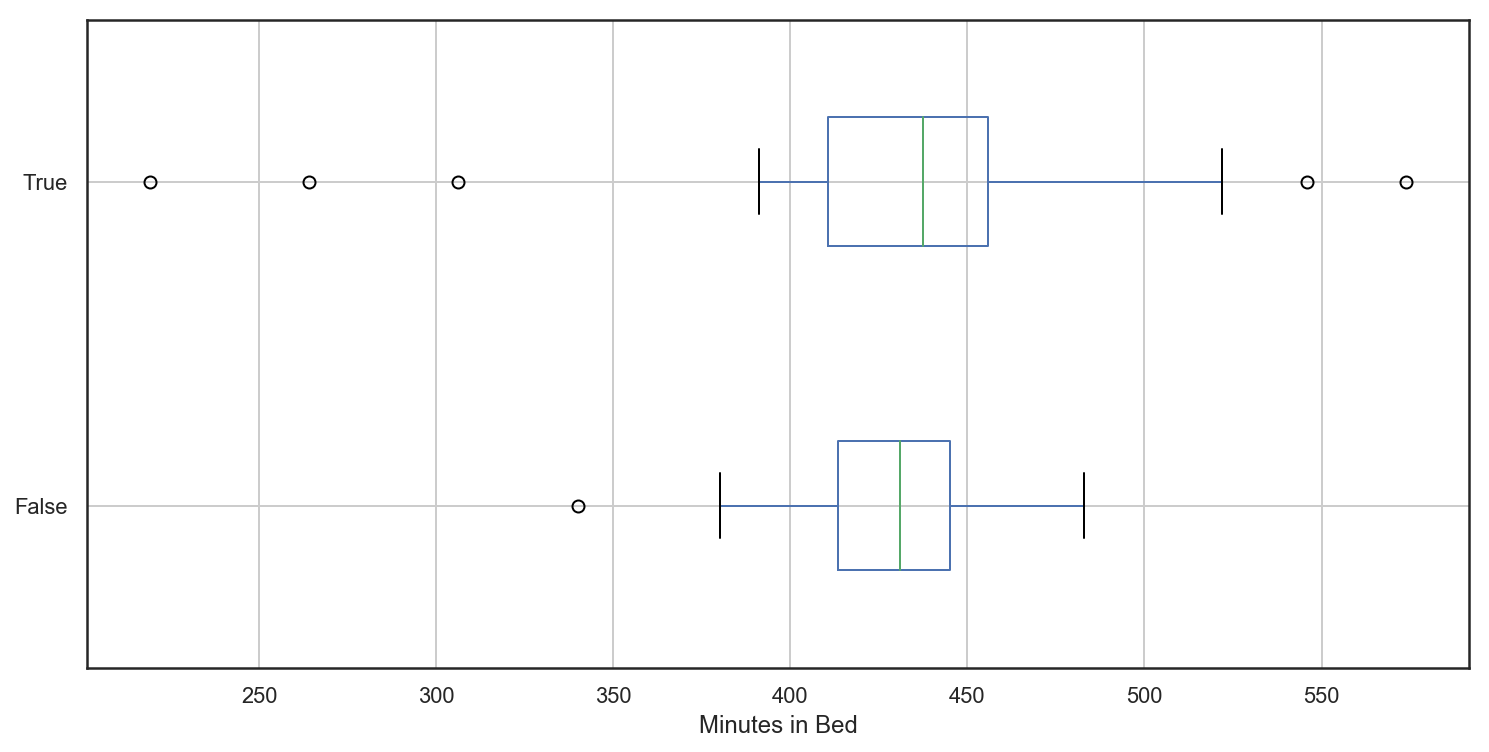

In [144]:
#使用boxplot（）函数绘制箱体图 ax，一个基本的箱体图从上到下分别表示最大值，上四分位，均值，下四分位，最小值。有的箱体图中还会加入异常值等
#应该是列取自Time in bed，从Is Weekend中得到
#vert：是否需要将箱线图垂直摆放，默认垂直摆放，widths：指定箱线图的宽度，默认为0.5
ax = sleepData.boxplot(column = 'Time in bed', by = 'Is Weekend', vert = False, widths = 0.4)
plt.xlabel('Minutes in Bed')    #设置横坐标标签名为 Minutes in Bed
plt.suptitle('')                #设置总标题为空
plt.title('');                  #设置标题为空
plt.show()

# The above plot shows that I tend to sleep a bit more on Weekends. The upper whisker is quite high for weekends 
indicatign varying sleep times.

let's check out how does the plots vary for indivisual days of the week.

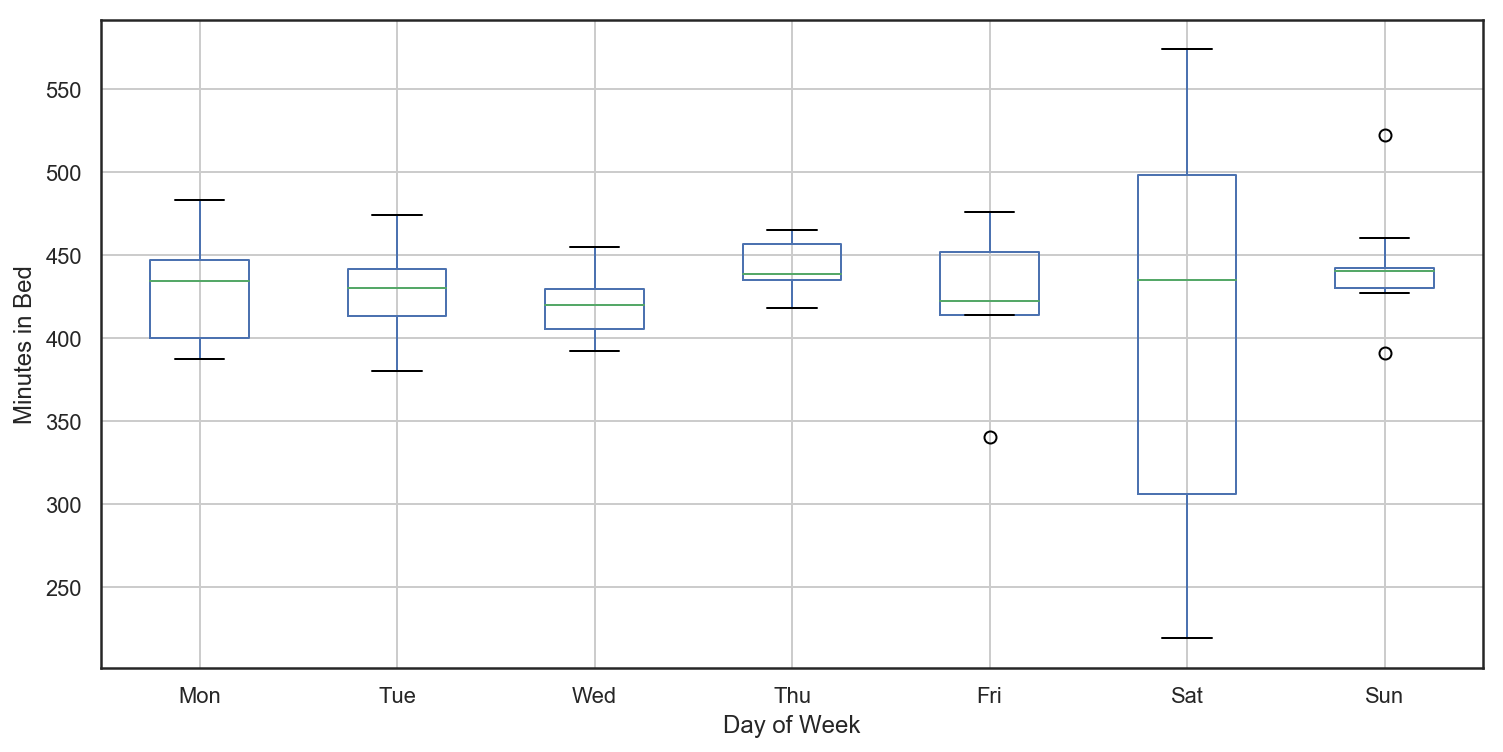

In [147]:
ax = sleepData.boxplot(column = 'Time in bed', by = 'Day of Week')    #绘制箱体图，应该是列数据取自Time in bed是从Day of Week中取
ax.set_xticklabels(minDayCodes[1:])         #设置横坐标标题标签取自minDayCodes从1到最后
plt.ylabel('Minutes in Bed')                #设置y轴标签名为Minutes in Bed
plt.suptitle('')                            #设置总标题为空
plt.title('');                              #设置标题为空
plt.show()

This is pretty interesting. 
The rest of the days are straighforward with lesser deviations but from the looks of it, I have exploited saturday night sleep for sure! 

## Coorelation of sleep with other activity numbers

In [148]:
sleepData['8 > Sleep > 7'] = sleepData['Time in bed'] > 7*60    #字面意思
sleepData['Sleep > 7'] = sleepData['Time in bed'] > 7*60        #字面意思
sleepData['Sleep > 8'] = sleepData['Time in bed'] > 8*60        #字面意思
sleepData['Active mins > 50'] = sleepData['Minutes Very Active'] > 50        #字面意思
sleepData['Active mins > 60'] = sleepData['Minutes Very Active'] > 60        #字面意思
#使用logical_and()函数（逻辑与）对括号里逗号两侧的值进行逻辑与判断返回给sleepData['wee']
sleepData['wee'] = np.logical_and(sleepData['Sleep Bucket'] <= 23, sleepData['Awake Bucket'] <= 6.5)
# slept before 11 and woke up by 6:30
#sleepData

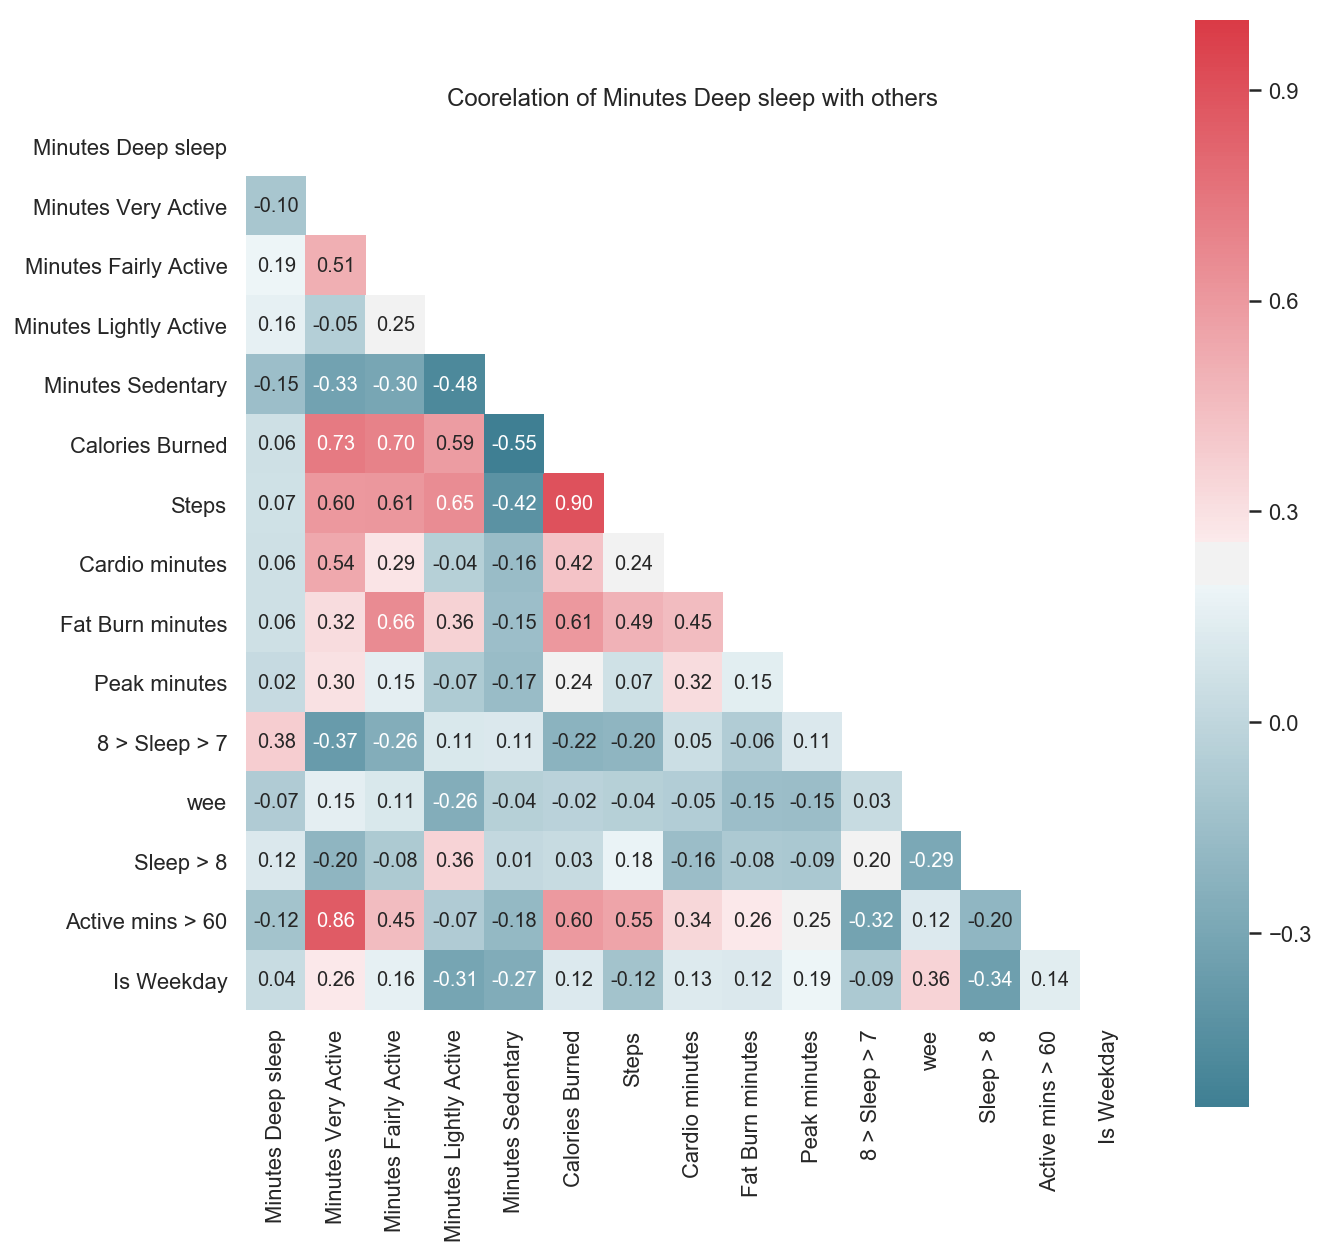

In [149]:
#定义关系为Minutes Deep sleep
correlationOf="Minutes Deep sleep"
k = 15 #number of variables for heatmap   热力图的变量设置为15
corrmat = sleepData[['Minutes Deep sleep', 'Minutes Very Active', 'Minutes Fairly Active', 'Minutes Lightly Active', 'Minutes Sedentary', 'Calories Burned', 'Steps',
          'Cardio minutes', 'Fat Burn minutes', 'Peak minutes',
          '8 > Sleep > 7', 'wee', 'Sleep > 8', 'Active mins > 60', 'Is Weekday']].corr()  #使用corr()函数进行关系处理
#corrmat = sleepData.drop(['% Restorative sleep', 'Minutes Light sleep', 'Minutes REM sleep', '% Deep sleep', '% Light sleep', '% REM sleep', 'REM sleep count', 'Deep sleep count', 'Light sleep count'], axis=1).corr().abs()
#cols = corrmat.nlargest(k, correlationOf)[correlationOf].index
#corrdf_sleep = sleepData[cols]

#绘制热力图，数据取自corrmat，关系为correlationOf，标题，风格不是黑色主题
plot_heatmap(corrmat, correlationOf, 'Coorelation of {} with others'.format(correlationOf), darkTheme=False)

## Machine Learning

Since we have some insights now on the activities and sleep. Let's see if we could use some of the basic ML techniques to see if there is a pattern to predict what are the ingredients for a decent sleep!

Though we have a handfulof data and vely less features, I don't expect to see some magic here. Will be repeating this once i have some more sleep data.

For now lets lay the basic template.

In [150]:
sleepData.head()   #显示头部信息？？

,Date,Day of Week,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Sleep Start time,Sleep End time,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Day Label,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins,8 > Sleep > 7,Sleep > 7,Sleep > 8,Active mins > 50,Active mins > 60,wee
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-24,2018-06-24,7,False,True,1996,1690,3367,3.01,0.00,59.0,0,1377,47,2,14,362,-1,11.0,133.10892,14.0,89.20880,0.0,0.0,446.51352,284.0,92.0,379.0,0.0,2018-06-24T22:17:00.000,2018-06-25T05:28:30.000,431.0,56.0,2.0,244.0,26.0,79.0,6.0,52.0,25.0,13.0,57.0,19.0,Sun,False,22.5,5.5,11.0,32.0,135.0,True,True,False,False,False,True
2018-06-25,2018-06-25,1,True,False,2863,1685,8394,5.55,36.58,58.0,12,709,244,42,14,1361,-1,2.0,12.40518,94.0,514.11279,0.0,0.0,2311.92765,1326.0,95.0,333.0,0.0,2018-06-25T22:49:30.000,2018-06-26T05:16:30.000,387.0,75.0,3.0,214.0,27.0,44.0,7.0,54.0,30.0,20.0,56.0,12.0,Mon,False,23.0,5.5,12.0,32.0,119.0,False,False,False,False,False,True
2018-06-26,2018-06-26,2,True,False,3398,1683,13569,9.68,24.38,57.0,8,687,231,33,102,2004,-1,10.0,103.59112,187.0,1245.54876,0.0,0.0,2034.05724,1232.0,89.0,351.0,0.0,2018-06-26T22:25:30.000,2018-06-27T05:07:30.000,402.0,53.0,3.0,223.0,28.0,75.0,7.0,51.0,29.0,14.0,56.0,19.0,Tue,True,22.5,5.5,11.0,33.0,128.0,False,False,False,True,True,True
2018-06-27,2018-06-27,3,True,False,3442,1682,13337,9.33,33.53,57.0,11,665,243,30,100,2035,-1,11.0,114.28908,217.0,1310.46804,0.0,0.0,1986.03570,1187.0,97.0,365.0,0.0,2018-06-27T22:36:30.000,2018-06-28T05:24:00.000,407.0,66.0,4.0,197.0,32.0,102.0,10.0,42.0,32.0,17.0,49.0,26.0,Wed,True,23.0,5.5,8.0,43.0,168.0,False,False,False,True,True,True
2018-07-01,2018-07-01,7,False,True,1718,1681,155,0.09,0.00,58.0,0,1427,13,0,0,46,-1,0.0,0.00000,1.0,3.97018,0.0,0.0,233.77354,171.0,96.0,402.0,0.0,2018-07-01T22:34:00.000,2018-07-02T05:54:30.000,440.0,77.0,5.0,233.0,34.0,92.0,8.0,38.0,34.0,18.0,53.0,21.0,Sun,False,23.0,6.0,8.0,39.0,169.0,True,True,False,False,False,True


## Regression

In [151]:
from sklearn.model_selection import train_test_split    #导入某个库里的模型

Let's build our training and test dataset

In [152]:
#设置变量x，y
y = sleepData['Minutes Deep sleep']
X = sleepData[['Calories Burned', 'Steps', 'Elevation (Ft)', 'Floors', 'Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active', 'Fat Burn minutes', 'Active exercise', 'Time in bed', 'Sleep Bucket', 'Day of Week']]
X.fillna(X.mean(), inplace=True)    #使用fillna()函数填充空值 例如使用 X.mean()（对X里各值求平均值）填充 X 的空值，inplace=Teue表示填充值在原数据上修改不新建表

#label encode the category values
#使用get_dummies()函数，该方法可以将类别变量转换成新增的虚拟变量/指示变量。
# X 为输入的数据，columns是指定需要列转换的列，   这里可能是把表格里前面的列都删了就剩下最后两个列了赋值给X
X = pd.get_dummies(X, columns=['Day of Week', 'Sleep Bucket'])   

#X_train，y_train：得到的训练数据，X_test， y_test：得到的测试数据，X,y：原始数据
#test_size=0.33是将原始数据打乱得到新顺序的训练数据和测试数据，测试数据的规格为原始数据的0.33
#random_state：Pseudo-random number generator state used for random sampling用于随机抽样的伪随机数发生器状态
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('X shape: {}'.format(X.shape))    #使用format()函数，用于字符串的格式化，使用shape()函数，它的功能是读取矩阵的长度，这里是X有76列29行
print('Y shape: {}'.format(y.shape))    #使用format()函数，用于字符串的格式化，打印Y是与76列，一行

X shape: (69, 29)
Y shape: (69,)


### Linear Regression

In [153]:
from sklearn import linear_model   #从sklearn库里导入 linear_model 线性模型
#分类任务常用指标包含混淆矩阵、每类分类精度、平均分类精度、总体分类精度、f1-score等。 
#Python的sklearn.metrics 模块覆盖了分类任务中大部分常用的验证指标，
#mean_squared_error  即均方误差是一个评价尺度是一个公式  r2_scorer2_score R2决定系数（拟合优度） 这是两个评价回归模型 
from sklearn.metrics import mean_squared_error, r2_score  #从sklearn.metrics里导入mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()   #使用线性模型里的回归模型

# Train the model using the training sets
regr.fit(X_train, y_train)               #使用fit（）函数调用，意思是使用这个函数括号里的数据来拟合刚刚创建的线性模型

# Make predictions using the testing set
lr_y_pred = regr.predict(X_test)         #使用predict()函数令模型去预测括号里的数据，使用训练好的分类器去预测括号里的数据
                        
print("Mean squared error: %.2f"% mean_squared_error(y_test, lr_y_pred))   #对结果使用均方差打印出来
#coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)
#coefficients

Mean squared error: 1727.03


### XGboost

In [154]:
#XGBoost算法现在已经成为很多数据工程师的重要武器。它是一种十分精致的算法，可以处理各种不规则的数据
import xgboost as xgb   

from xgboost.sklearn import XGBRegressor  #从xgboost.sklearn模块中导入XGBRegressor 回归
#GridSearchCV自动搜索模块，能够在指定的范围内自动搜索具有不同超参数的不同模型组合，有效解放注意力。
from sklearn.model_selection import GridSearchCV  #从sklearn.model_selection 中导入GridSearchCV

xgbR = XGBRegressor()                                 #使用XGBRegressor（）函数
parameters = {'objective':['reg:linear'],             #定义变量并赋值
              'learning_rate': [.03, 0.05, .07, 0.1],
              'max_depth': [3, 4, 5, 6],
              'min_child_weight': [1, 5, 10],
              'silent': [1],
              'n_estimators': [100, 300, 500],
              'seed': [1212]
             }

#使用GridSearchCV模块，使用XGBRegressor（）函数，对parameters数据进行操作，n_jobs=5是cpu使用5个并行训练，是占用cpu，
#verbose表示详细信息，verbose=True，意思就是设置运行的时候显示详细信息
xgb_grid = GridSearchCV(xgbR, parameters, n_jobs = 5, verbose=True)  
xgb_grid.fit(X_train, y_train)    #使用fit()函数，即对xgb_grid使用括号里数据进行拟合训练

print(xgb_grid.best_score_)     #这里应该是打印某个结果best_score_
print(xgb_grid.best_params_)    #同上反正我不知道是啥但是应该是一个结果

y_pred = xgb_grid.predict(X_test)     #使用predict()函数令模型预测括号里的数据
print ("RMSE : ",mean_squared_error(y_test,y_pred))    #打印均方差处理过的数据

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   15.2s


0.0166306639806
{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'objective': 'reg:linear', 'seed': 1212, 'silent': 1}
RMSE :  229.499359444


[Parallel(n_jobs=5)]: Done 432 out of 432 | elapsed:   30.2s finished


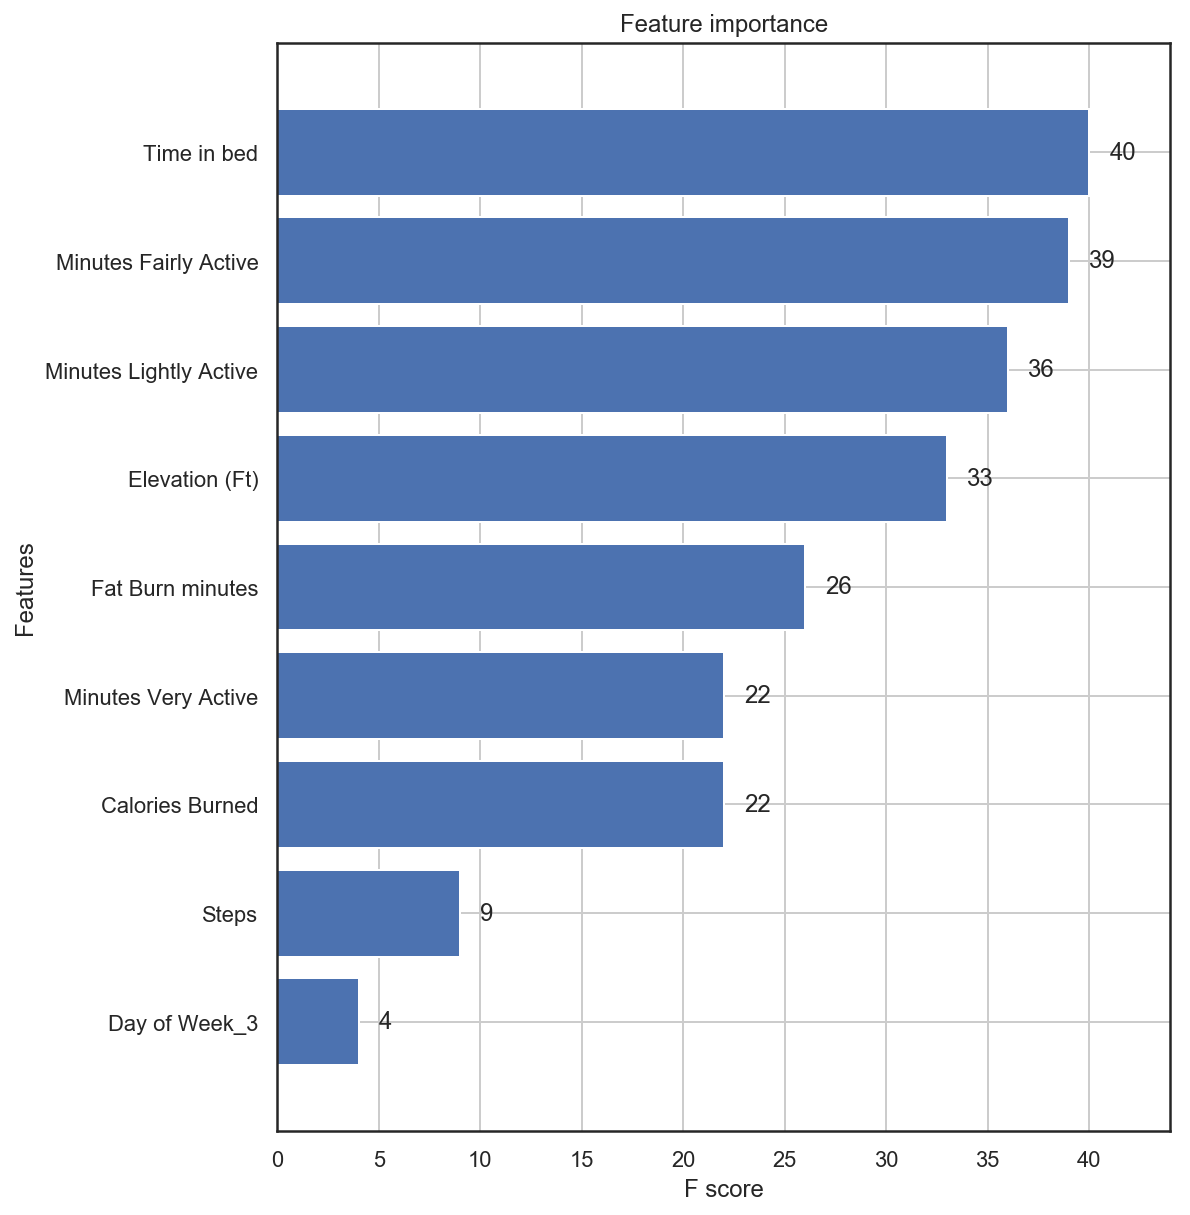

In [155]:
fig, ax = plt.subplots(figsize=(8,10))      #使用subplots()函数绘制窗口8*10  fig和ax
xgb.plot_importance(xgb_grid.best_estimator_, height=0.8, ax=ax)    #plot_importance()没找到这个函数的作用不过应该也是作图的就对了
plt.show()
#y_pred = xgb_grid.predict(X_test)

### Classification

In [156]:
#决策树（Decision Trees ，DTs）是一种无监督的学习方法，用于分类和回归。它对数据中蕴含的决策规则建模，以预测目标变量的值。
from sklearn.tree import DecisionTreeClassifier          #导入DecisionTreeClassifier（决策树分类器）
from sklearn import tree                                 #导入tree 树

#accuracy_score （分类准确率分数）是指所有分类正确的百分比。分类准确率这一衡量分类器的标准比较容易理解，但是它不能告诉你响应值的潜在分布，并且它也不能告诉你分类器犯错的类型。
from sklearn.metrics import accuracy_score               #从sklearn.metrics模块中导入accuracy_score（分类准确率分数）
from sklearn.metrics import classification_report        #sklearn中的classification_report函数用于显示主要分类指标的文本报告．在报告中显示每个类的精确度，召回率，F1值等信息。
from sklearn.metrics import confusion_matrix             #confusion_matrix(混淆矩阵

import graphviz                                          #graphviz库，用于生成决策树、流程图效果拔群



def trainAndPredict(classifier):                         #定义训练和预测括号参数是分类器
    classifier.fit(X_train, y_train)                     #使用fit()函数对分类器进行拟合            
    y_pred = classifier.predict(X_test)                  #使用predict()函数对分类器进行预测
    
    print ("Accuracy : ",accuracy_score(y_test,y_pred)*100)          #打印准确度
    print("Report : ",classification_report(y_test, y_pred))         #打印报告结果
    #print("Confusion Matrix: ",confusion_matrix(y_test, y_pred))
    return

def plotGraph(classifier):                                           #定义绘制绘制图表函数括号里是分类器
    dot_data = tree.export_graphviz(classifier, out_file=None,       #export_graphviz好像是决策树可视化
                         feature_names=X.columns.values,  
                         class_names=['Yes', 'No'],                                
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)                                #？？？没查到graphviz.Source()这个函数干嘛的
    return graph

In [157]:
#定义变量X，并赋值
X = sleepData[['Day of Week', 'Calories Burned', 'Steps', 'Elevation (Ft)', 'Floors', 'Minutes Sedentary', 'Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active', 'Fat Burn minutes', 'Active exercise', 'Time in bed']]
X.fillna(X.mean(), inplace=True)               #使用fillna()函数对X中空值使用X.mean()进行填充，inplace=Teue表示填充值在原数据上修改不新建表

Y = sleepData['% Restorative sleep'] > 35      #定义Y并赋值

print('X shape: {}'.format(X.shape))           #使用format()函数用于字符串的格式化，使用shape()函数，它的功能是读取矩阵的长度，这里是X有76列12行
print('Y shape: {}'.format(Y.shape))           #同上这里Y是76列1行

#X_train，y_train：得到的训练数据，X_test， y_test：得到的测试数据，X,y：原始数据
#test_size=0.3是将原始数据打乱得到新顺序的训练数据和测试数据，测试数据的规格为原始数据的0.3
#random_state：Pseudo-random number generator state used for random sampling用于随机抽样的伪随机数发生器状态
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
print('X_train shape: {}. X_test shape: {}'.format(X_train.shape, X_test.shape))     #打印X训练集测试集行列

X shape: (69, 12)
Y shape: (69,)
X_train shape: (48, 12). X_test shape: (21, 12)


Accuracy :  42.8571428571
Report :                precision    recall  f1-score   support

       False       0.35      0.86      0.50         7
        True       0.75      0.21      0.33        14

   micro avg       0.43      0.43      0.43        21
   macro avg       0.55      0.54      0.42        21
weighted avg       0.62      0.43      0.39        21



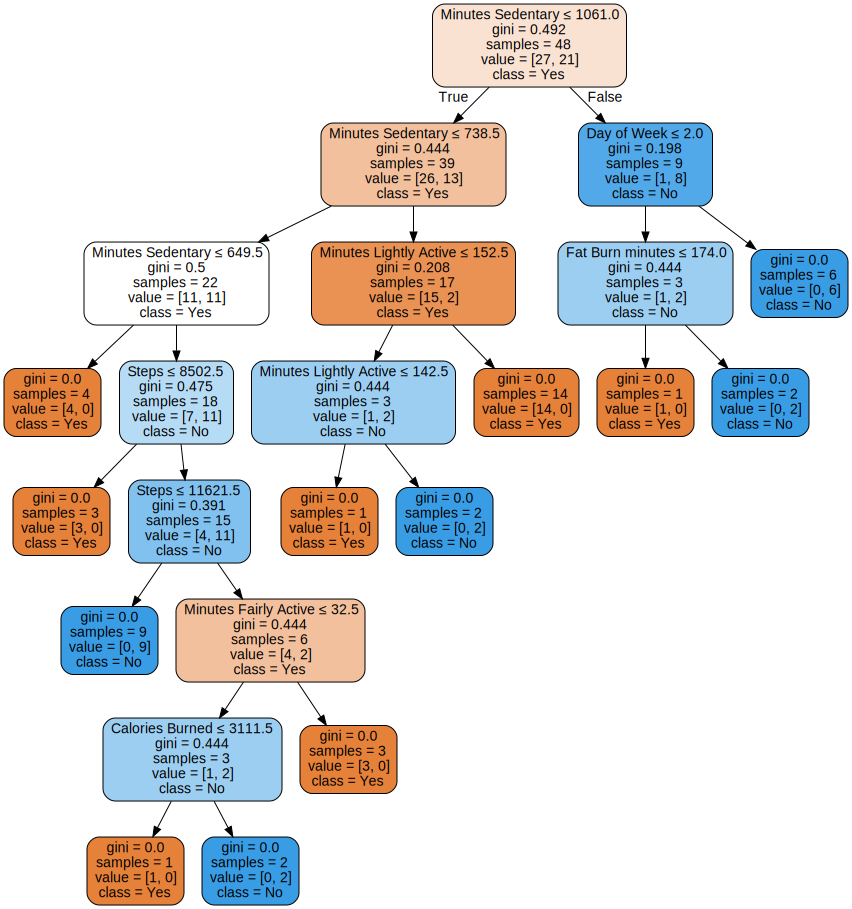

In [158]:
clf_gini_default = DecisionTreeClassifier(criterion = "gini")
trainAndPredict(clf_gini_default)
plotGraph(clf_gini_default)